In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions

from importlib import reload

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_seconds = 86400

## Looking for ETVs in TIC 130946041 (EB2)

- 2+2, see: https://www.zooniverse.org/projects/vbkostov/eclipsing-binary-patrol/talk/6324/3578156?comment=5873532&page=1


In [3]:
# define the plotting parameters

figsize = (8,4)

In [21]:
# import the data

# choose a TIC ID to analyze
ticid = 130946041

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary_eb2.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary_eb2.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
# prefer QLP over TESS-SPOC for more uniform data 
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'QLP', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()

def use_sap_flux(lc):
    """Helper over select_flux("sap_flux") to ensure flux_err is populated for QLP case"""
    if lc.meta.get("AUTHOR") == "QLP":
        # select_flux("sap_flux") on QLP data will lead to nan flux_err
        # because QLP lc only has err on kspsap_flux / det_flux
        return lc
    else:
        return lc.select_flux("sap_flux")
lc_tess = lcc_tess.stitch(
    # corrector_func=lambda lc: lke.select_flux(lc, ["kspsap_flux", "det_flux"])  #  use detrended QLP for more uniform dips
)
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


lc_tess_all = lc_tess  # keep a reference of the data before masking

len(lc_tess_all)

SearchResult containing 3 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 10 2019    QLP    1800   130946041      0.0         N/A
  1 TESS Sector 37 2021   SPOC     120   130946041      0.0      G03272
  2 TESS Sector 64 2023    QLP     200   130946041      0.0         N/A

C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\lightkurve\collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg', 'sap_bkg_err', 'sap_flux'}
  warnings.warn(


29814

In [22]:
# The approx parameters of the 2 EBs
# transit_specs = TransitTimeSpecList(  # TIC 130946041, 2+2, possibly some ETV
#     dict(epoch=2307.3275, duration_hr=2.97127, period=0.396285, label="EB1",  # deep-n-shallow, likely some ETV
#          sector=37, steps_to_show=[6, 7],
#         ),
#     dict(epoch=3052.075, duration_hr=1.5, period=0.837245, label="EB2-deep", 
#          sector=64, steps_to_show=[0, 1],
#         ),
#     defaults=dict(surround_time=0.5)
# )

# mask out EB1
duration_factor = 1.4  # mask out some OOT cadence to ensure variation due to transits/eclipses are masked, generous factor to account for the likely ETV
tmask = lc_tess_all.create_transit_mask(transit_time=2307.3275, period=0.396285, duration=2.98 / 24 * duration_factor)
lc_tess = lc_tess_all[~tmask]
len(lc_tess)

16738

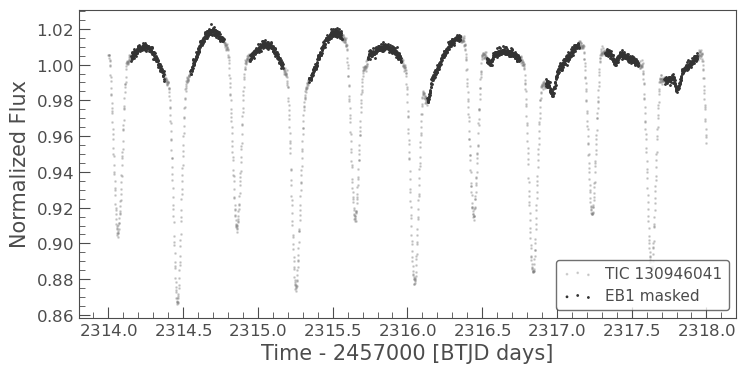

In [23]:
# visualize the mask effect
ax = lc_tess_all.truncate(2314, 2318).scatter(c="gray", alpha=0.3);
ax = lc_tess.truncate(2314, 2318).scatter(ax=ax, label="EB1 masked");

In [24]:
search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

16738

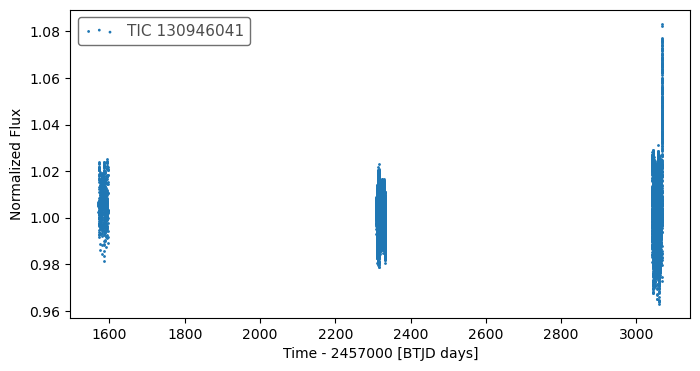

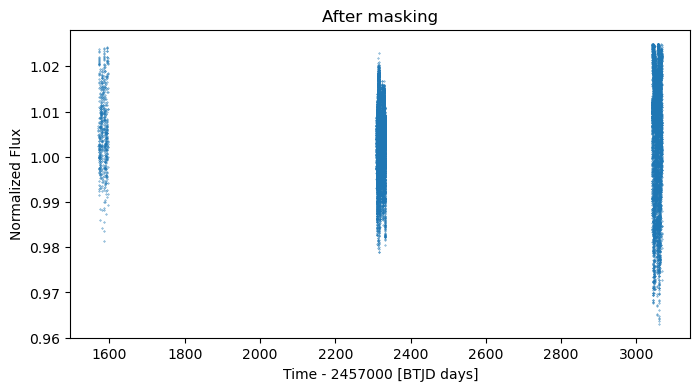

In [31]:
search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value

# mask out extrra data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

# mask = time < 0  # no mask
mask = flux > 1.025  #  outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [9]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [10]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [11]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

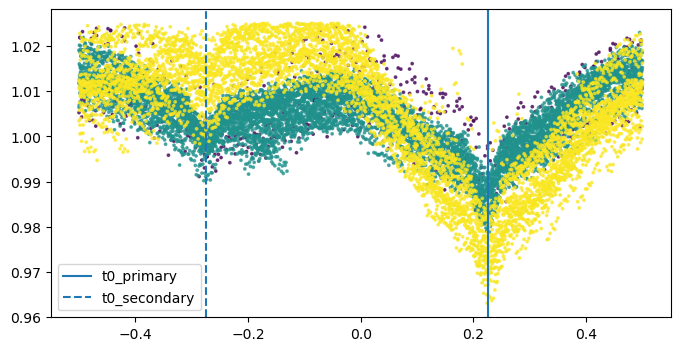

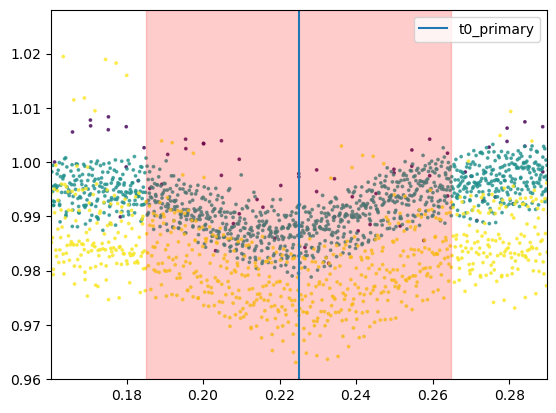

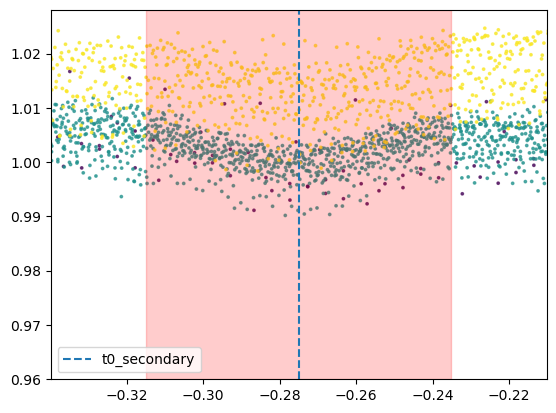

In [38]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0

# epoch=3052.075, duration_hr=1.5, period=0.837245, label="EB2-deep", 
# MCMC on df_primary [clipped LC D*0.8]: p=0.8372437751071118, std_p: inf ; t0=1570.151778546097,std_t0: inf
# MCMC on df_primary [clipped LC D*2]:   p=0.8372522073806763, std_p: 1.9189626626370285e-06 ; t0=1570.9776196621633, std_t0: 0.0017386636773753824

# FILL-IN THE eclipse epoch / period,
period = 0.837245  # manual
# period = 0.83725 # MCMC [clipped LC D*2], error of 1.9e-6, so the manuakl one seems to fit better visually

t0_primary = 3052.075   # manual, auto-shifted to 1570.1513499999999 
# t0_primary = 1570.977  # MCMC

# t0_secondary = None  # ignore shallow one for now
t0_secondary = t0_primary + period / 2

duration_hr_primary = 1.6
duration_hr_secondary = 1.6


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

NameError: name 'duration_hr_secondary' is not defined

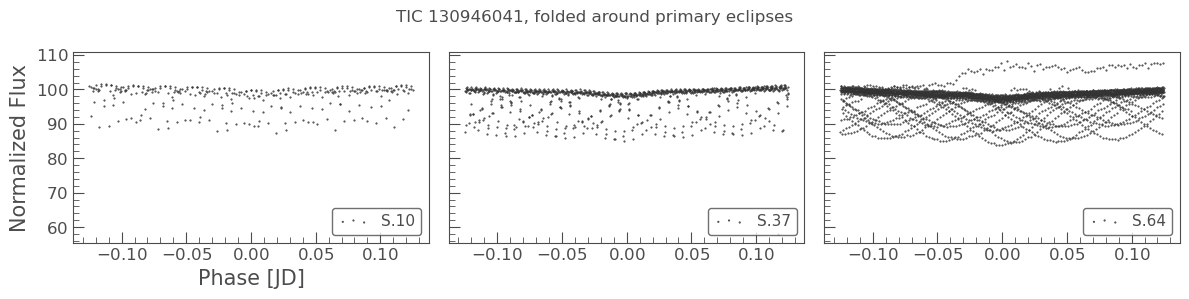

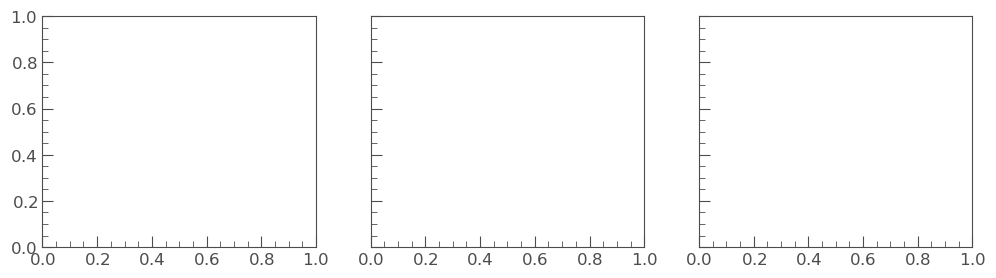

In [13]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
data["flux_original"] = data.flux  # save the original flux 

In [ ]:
# show data to visualize what's changed in each step below
data

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

In [ ]:
# # Uncomment to use the detrended flux
# #
# print("Use deterended flux")
# data.flux = data.flux_detrended

### Now that the data is ready we can start 

- generally the clipped LC window is ***smaller*** than the eclipse duration, to avoid the complication of fitting ingress/egress.

In [39]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 2 * duration_hr_primary / 24 / period   # include ingress/egress
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 2 * duration_hr_secondary / 24 / period
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)

    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase
# mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 0.9966156036421703, -0.010860372252090442, 1570.9776196621633, 0.025653227466031374, 0.7019115551765738, 0.8372522073806763, std_p: 1.9189626626370285e-06 ; std_t0: 0.0017386636773753824
start_vals = [0.995, -0.012, midpoint_p, 0.026, 0.85]
start_vals_s = [1.01, -0.007, midpoint_s, 0.02, 0.95]



# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1570.9885949999998 0.224999999999841
window_width_p (phase): 0.1592524689109321
Secondary: 1571.4072174999997 -0.2750000000003312
window_width_s (phase): 0.1592524689109321


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[0.9967, -0.01086, 1570.9885949999998, 0.0257, 0.7, 0.837245],


In [ ]:
if False:
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|████████████████████████████████████████████████████████| 13000/13000 [21:44<00:00,  9.96it/s]


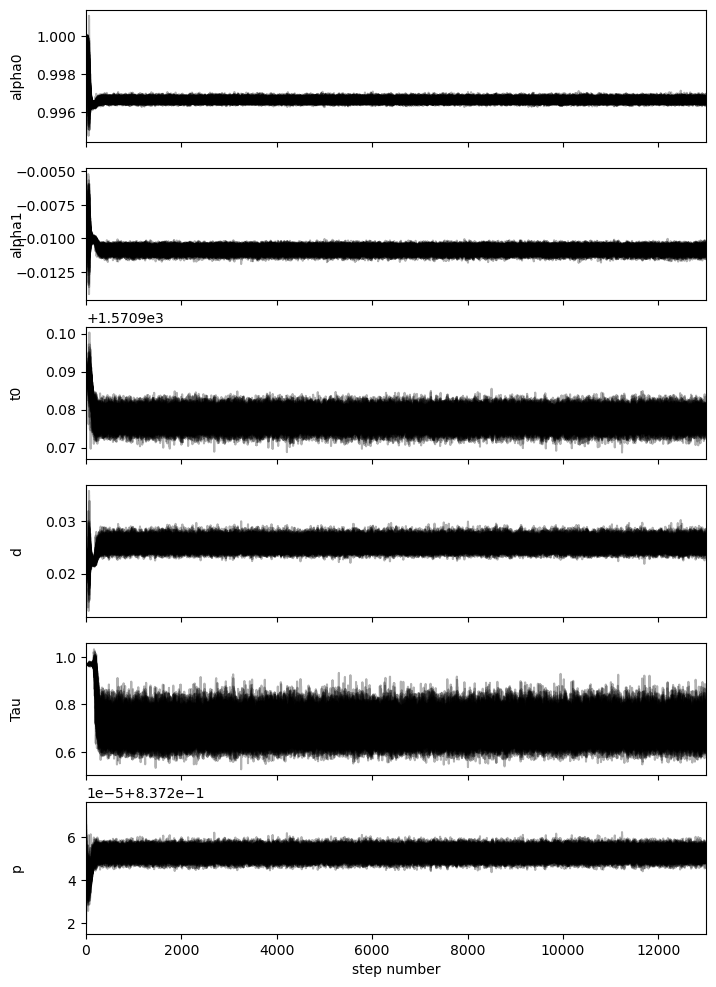

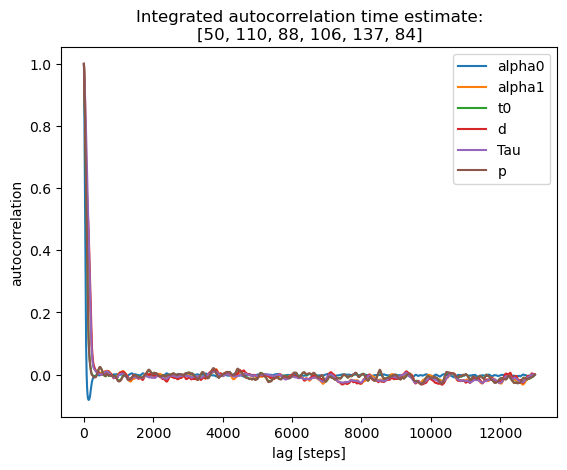

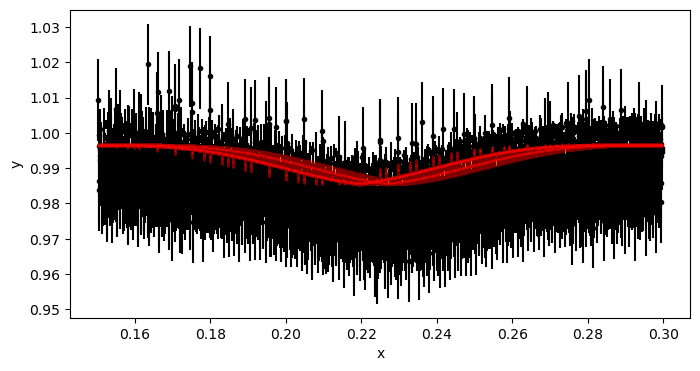

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 0.9966156036421703, -0.010860372252090442, 1570.9776196621633, 0.025653227466031374, 0.7019115551765738, 0.8372522073806763
std_p: 1.9189626626370285e-06 ; std_t0: 0.0017386636773753824


In [34]:
# use MCMC to refine the period (run with large clipped LC window of D*2)

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.0, -0.01, 1570.9885949999998, 0.021, 0.97, 0.837245],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=13000, discard=1000,
        autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient
        pool=-2,
        plot_chains=True,
        plot_autocorrelation=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|████████████████████████████████████████████████████████| 13000/13000 [07:13<00:00, 29.98it/s]
C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\autocorr.py:37: RuntimeWarning: overflow encountered in multiply
  acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]
The chain is shorter than 20 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 650;
tau: [258.72837812 261.55420898          nan 658.98967487 628.67010306
          nan]


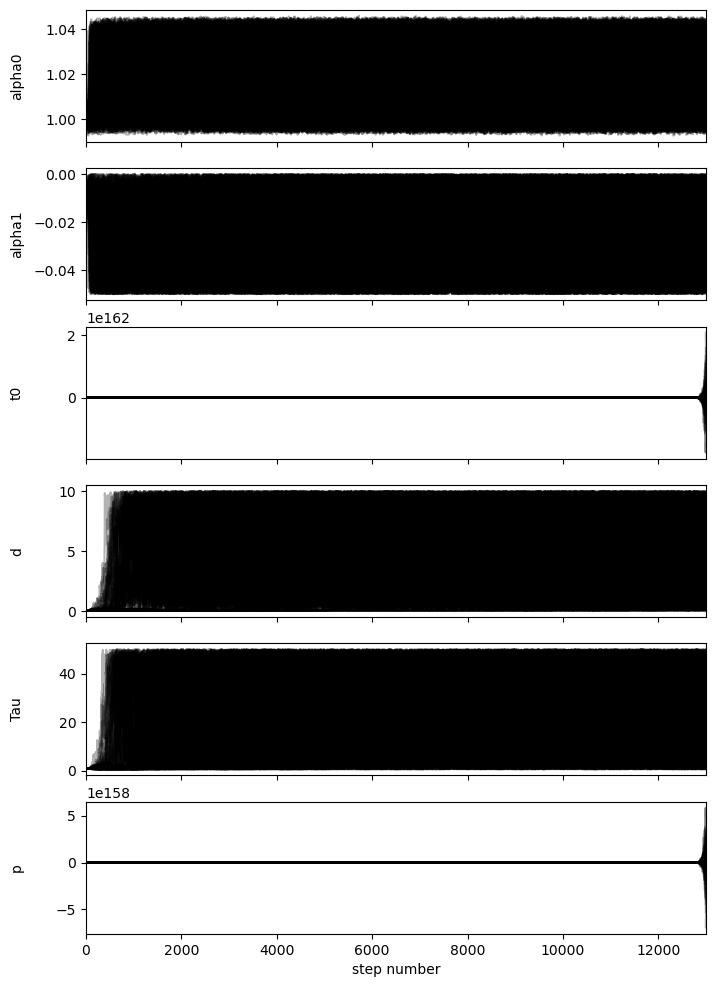

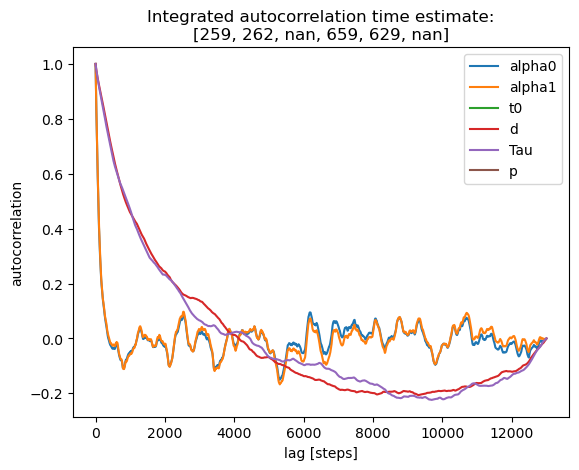

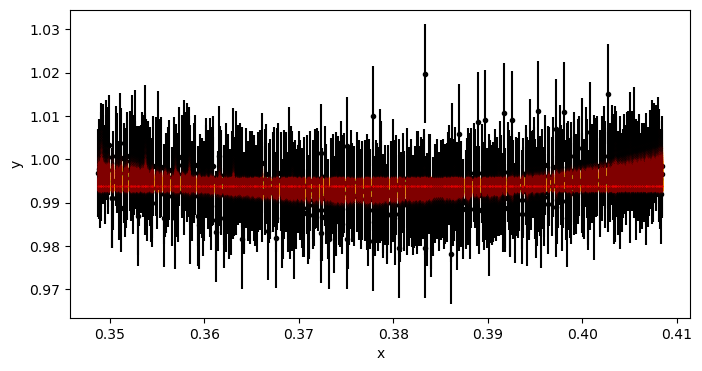

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0192703409343977, -0.02549170955825057, 1570.151778546097, 4.0192479069754965, 20.595757427971765, 0.8372437751071118
std_p: inf ; std_t0: inf


C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [18]:
# use MCMC to refine the period (run with narrow clipped LC window of D*0.8)

use_mcmc_to_fit_period = True

import etv_functions_with_period as etvp
reload(etvp)

# use a custom log_prior so that emcee won't waste time going over amplitude (alpha1) that is too large
# in order for use the custom log_prior in emcee, I then need to create a custom log_probability
def custom_log_prior_p(theta):
    alpha0, alpha1, t0, d, Tau, p = theta

    # restrict alpha1 (dip depth), comparing to the default prior
    if (0 < alpha0 < 10) and (-0.05 < alpha1 < 0) and (0 < d < 10) and (0.5 < Tau < 50):
        return 0.0
    return -np.inf

    
def custom_log_probability_p(theta, x, y, yerr):
    # check that the priors are satisfied
    lp = custom_log_prior_p(theta)
    if not np.isfinite(lp):
        res = -np.inf
    else:
        res = lp + etvp.log_likelihood_p(theta, x, y, yerr)
        print(f"DBG: {res} -- {theta}", flush=True)
    return res


if use_mcmc_to_fit_period:

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.0, -0.01, 1570.1513499999999, 0.021, 0.97, 0.837245],
        # log_probability_func=custom_log_probability_p, 
        log_probability_func=etvp.log_probability_p,  # somehow the custom_log_probability_p hangs, so I hack the evp module to change the prior with restrictive alpha1
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=13000, discard=1000,
        autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient
        pool=-2,
        plot_chains=True,
        plot_autocorrelation=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [03:43<00:00, 13.41it/s]


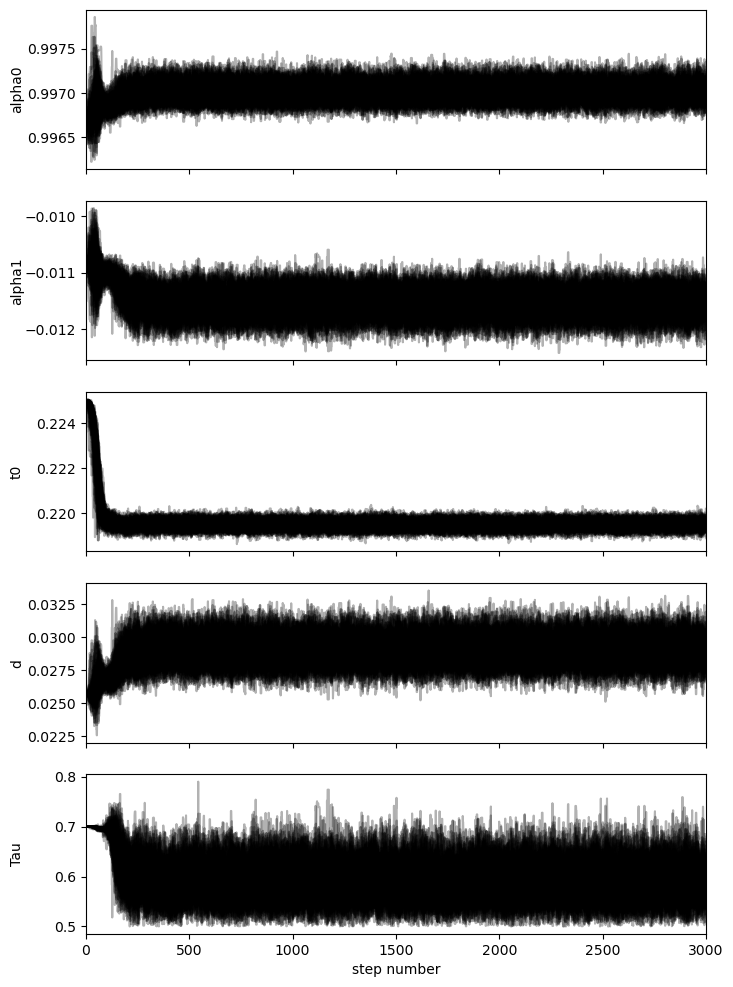

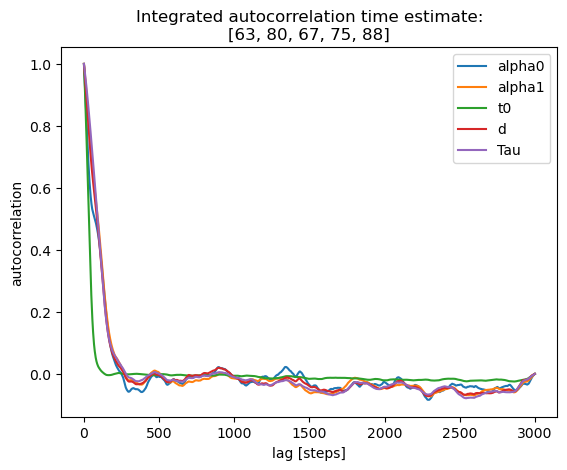

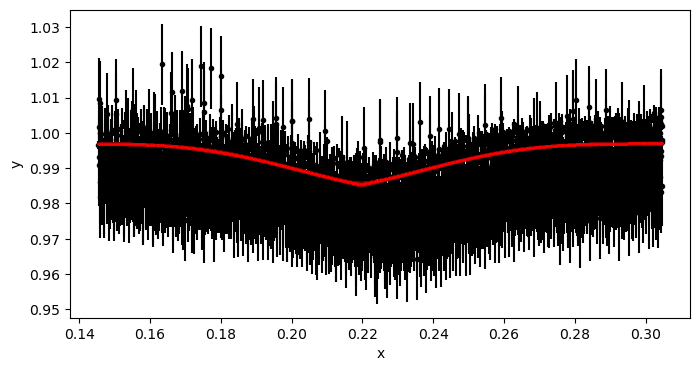

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [03:49<00:00, 13.10it/s]


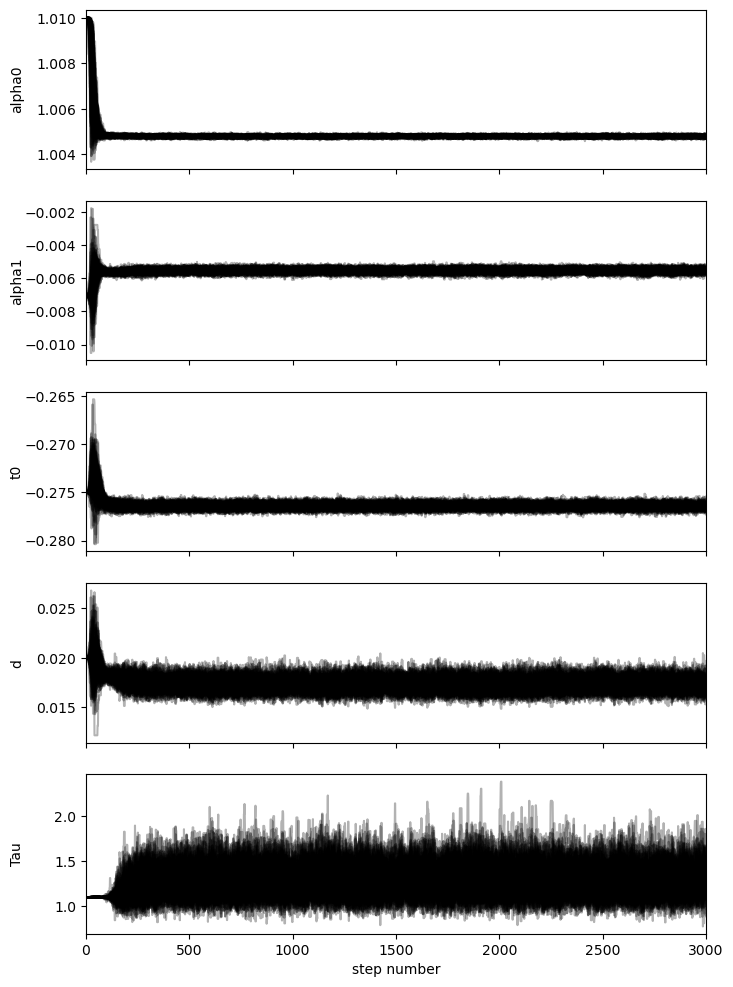

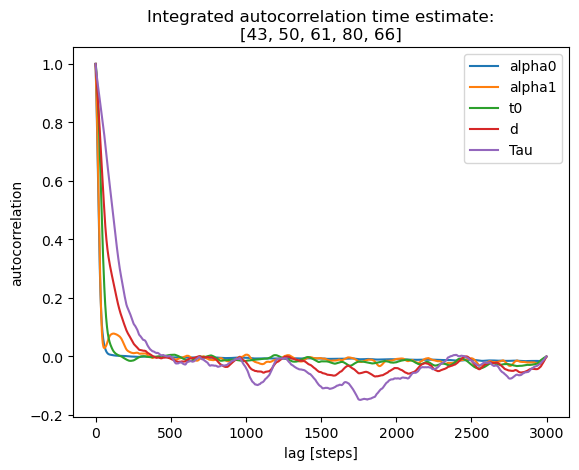

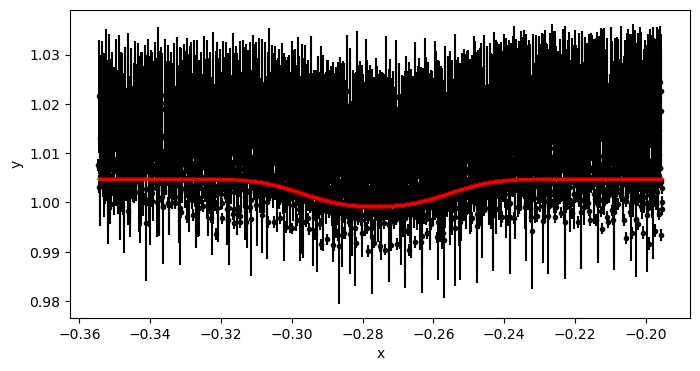

In [40]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, fit_params_stats = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=3000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, fit_params_s_stats = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=3000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")

    # params after cadences overlapping with EB1 are moved
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9970137121977671, -0.011523940735898013, 0.2194852084930069, 0.029008889520996693, 0.5895239616064472
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0047948336711348, -0.005532378302619059, -0.2764089015958582, 0.01729072221883348, 1.27595463224266

    
    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [41]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9970137121977671, -0.011523940735898013, 0.2194852084930069, 0.029008889520996693, 0.5895239616064472
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0047948336711348, -0.005532378302619059, -0.2764089015958582, 0.01729072221883348, 1.27595463224266


1788

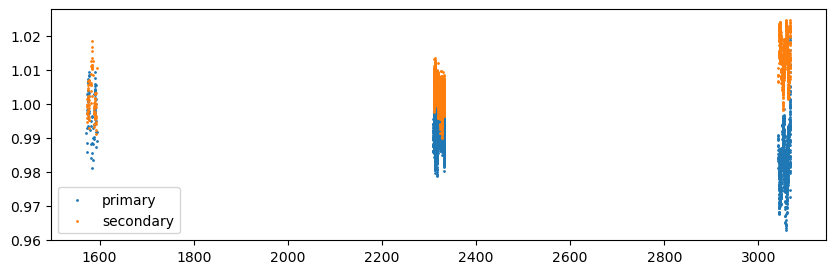

In [42]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1570.9885949999998 0.837245 1570.9885949999998


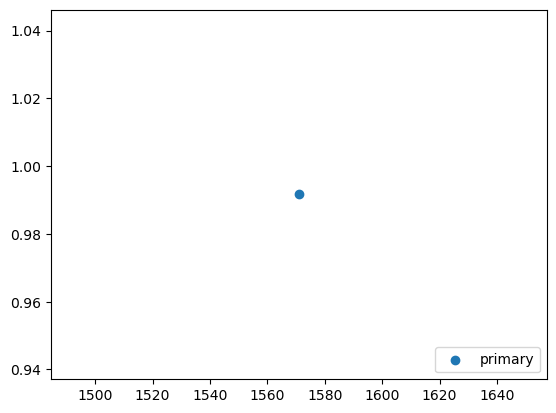

1570.9885949999998 0.837245 1571.8258399999997


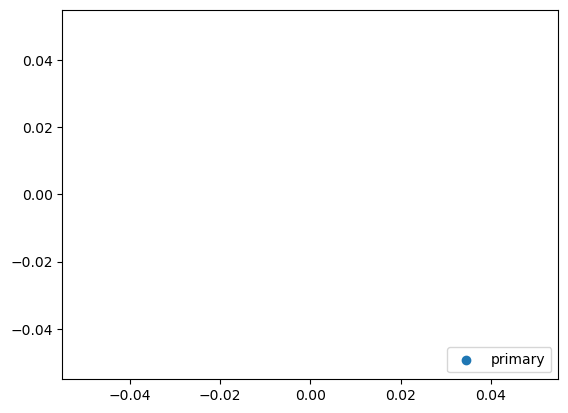

1570.9885949999998 0.837245 1572.663085


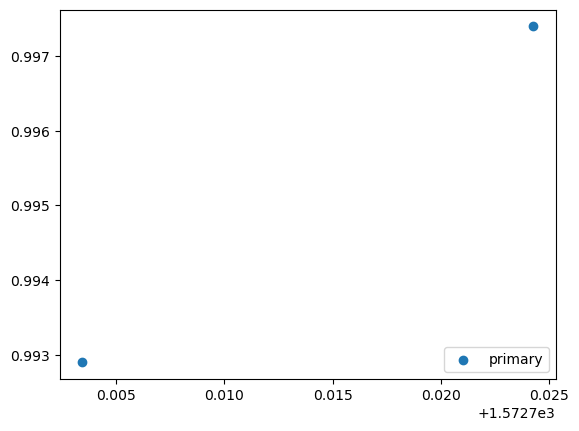

1571.4072174999997 0.837245 1571.4072174999997


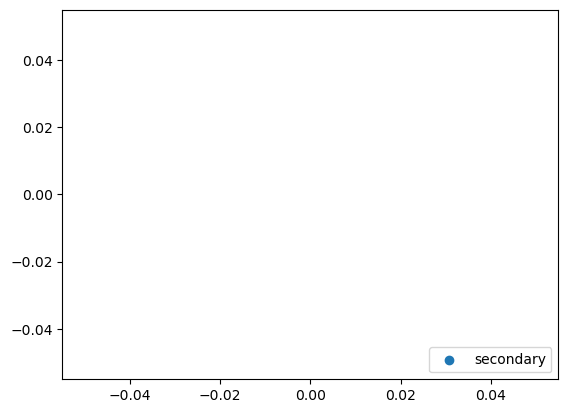

1571.4072174999997 0.837245 1572.2444624999996


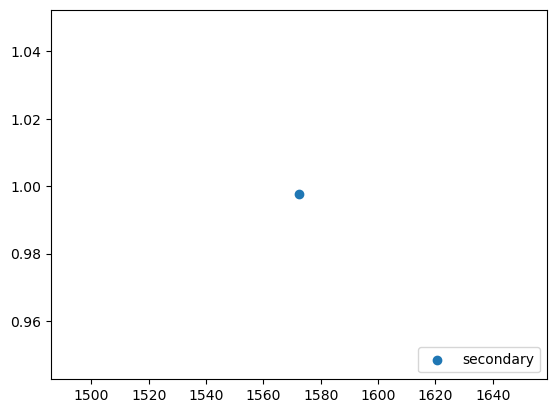

1571.4072174999997 0.837245 1573.0817074999998


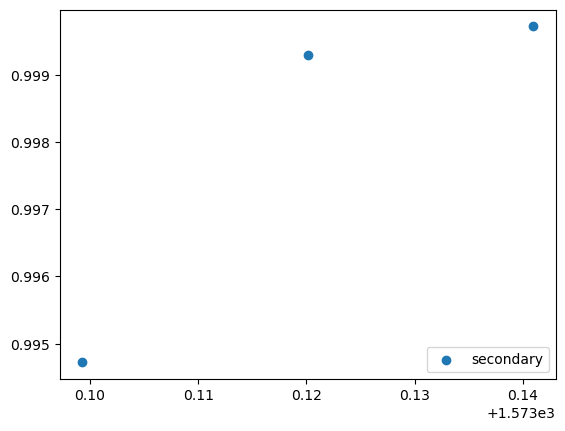

In [43]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux)
    yerr = np.array(data_primary.err)

    print (t0_primary, period, transit_time)

    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

    x = np.array(x[mask])
    y = np.array(y[mask])
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()


if t0_secondary is not None:
    for i in tr_index[0:3]:
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux)
        yerr = np.array(data_secondary.err)

        print (t0_secondary, period, transit_time)

        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit individual eclipses

In [44]:
# Provide a warning if the expected number of data points per clipped LC is smaller than the default minimum `min_number_data` (20)
longest_cadence = np.max(sr.exptime)
est_number_data_primary   = int(duration_hr_primary / longest_cadence.to(u.hr).value)
print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for primary: {est_number_data_primary}")
if est_number_data_primary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (primary) < 20"))

if t0_secondary is not None:
    est_number_data_secondary = int(duration_hr_secondary / longest_cadence.to(u.hr).value)
    print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for secondary:  {est_number_data_secondary}")
    if est_number_data_secondary < 20:
        display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (secondary) < 20"))

Expected num of data points of a clipped LC in longest cadence (1800.0 s) for primary: 3


Expected num of data points of a clipped LC in longest cadence (1800.0 s) for secondary:  3


Fitting individual primary eclipses...
Creating new manifest file
Time 1570.9885949999998 does not have enough data points: 1
Time 1572.663085 does not have enough data points: 2
1573.5003299999998 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 491.25it/s]


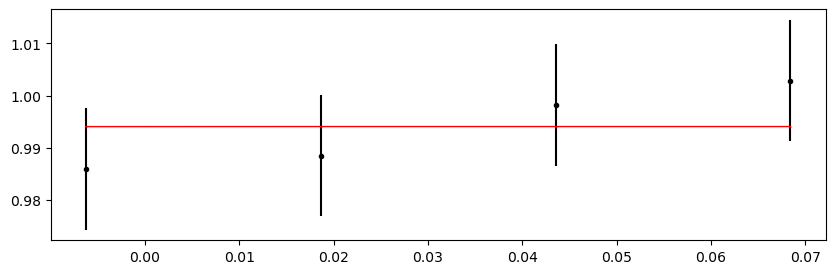

1574.3375749999998 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 456.69it/s]


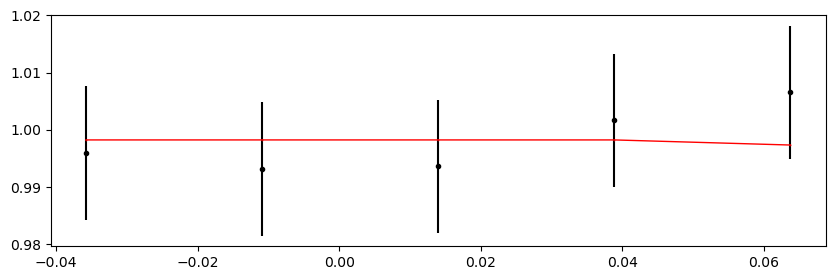

1575.1748199999997 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 485.74it/s]


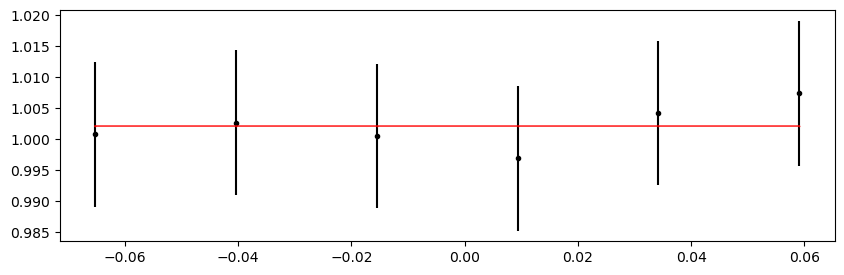

1576.012065 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 489.76it/s]


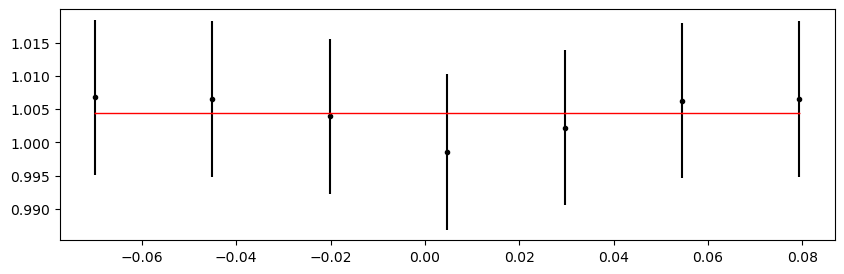

1576.8493099999998 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 481.98it/s]


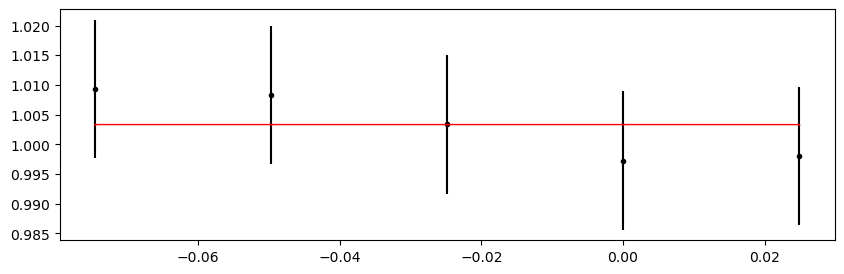

1577.6865549999998 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.86it/s]


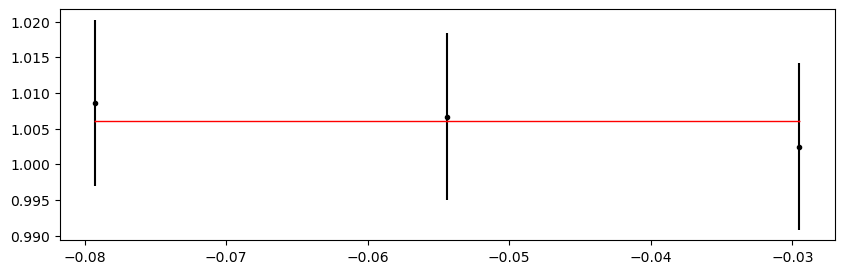

Time 1580.1982899999998 does not have enough data points: 1
1581.0355349999998 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 501.89it/s]


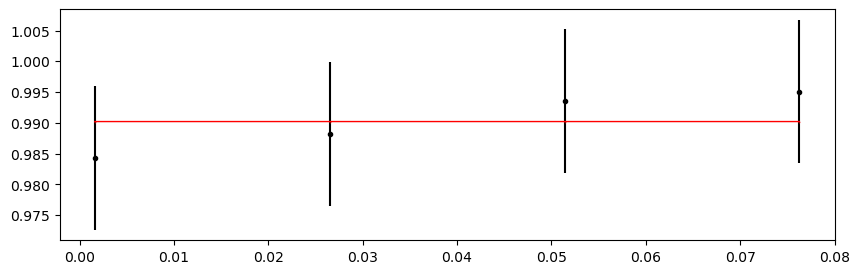

1584.3845149999997 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 493.80it/s]


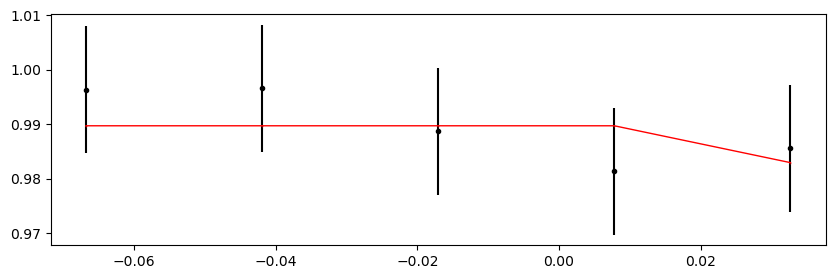

1585.22176 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 473.70it/s]


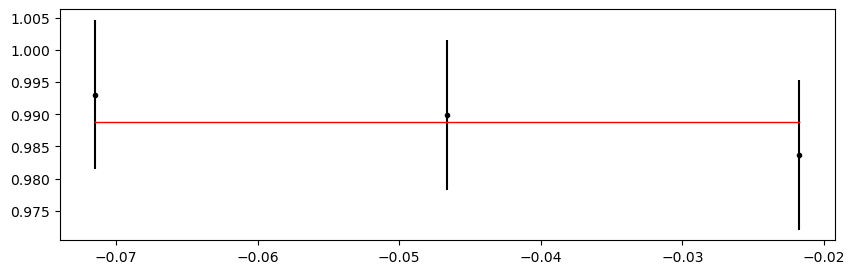

Time 1586.0590049999998 does not have enough data points: 1
Time 1587.7334949999997 does not have enough data points: 2
1588.57074 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 479.90it/s]


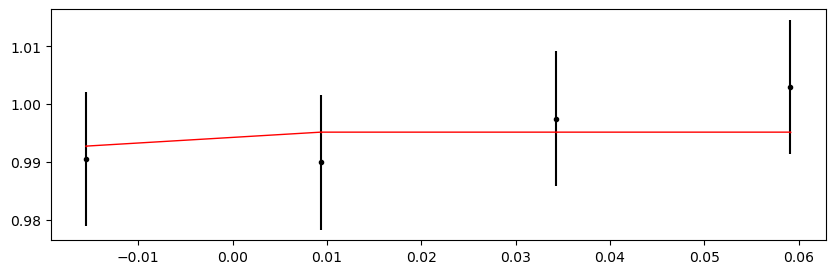

1589.4079849999998 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 492.64it/s]


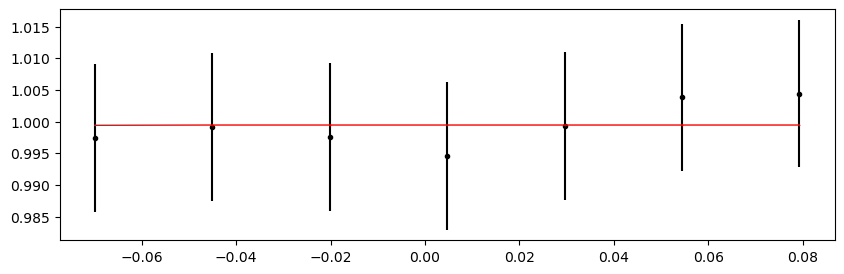

1590.2452299999998 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 494.56it/s]


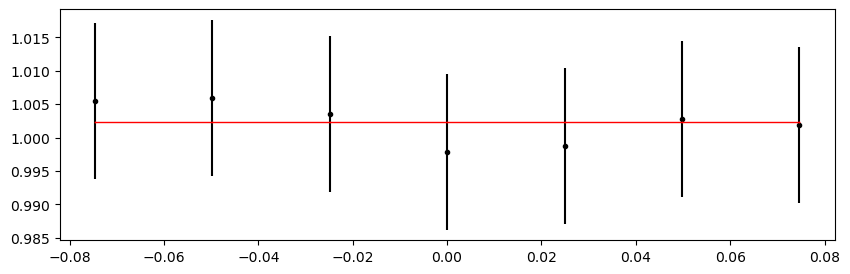

1591.0824749999997 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 503.98it/s]


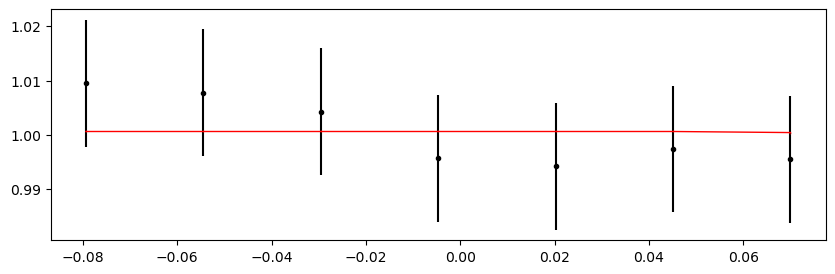

1591.9197199999999 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 493.07it/s]


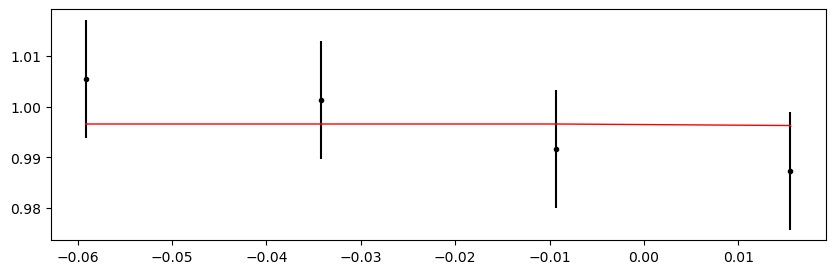

Time 1592.7569649999998 does not have enough data points: 2
Time 1595.2686999999999 does not have enough data points: 2
2309.438685 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.72it/s]


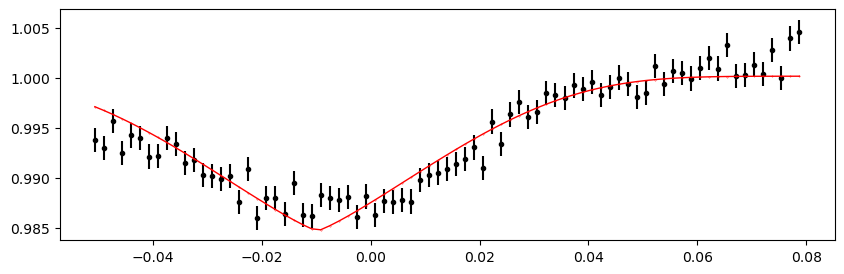

2310.27593 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 352.74it/s]


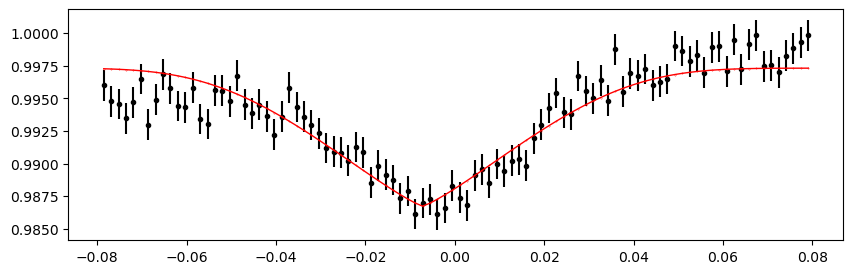

2311.113175 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.98it/s]


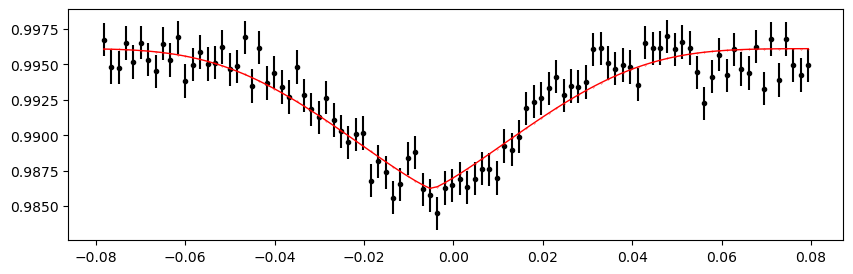

2311.9504199999997 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.93it/s]


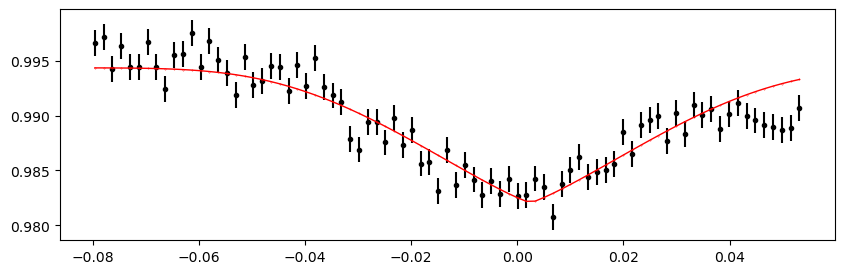

2312.787665 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.64it/s]


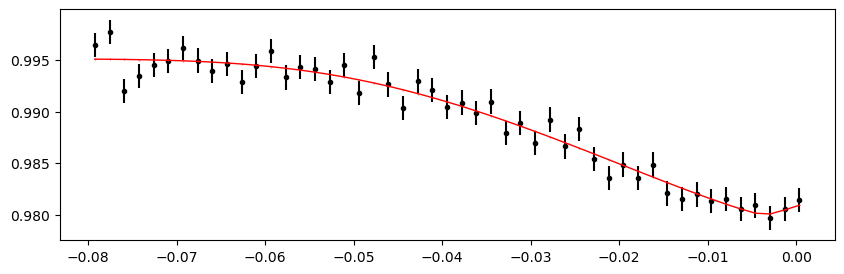

2313.6249099999995 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 487.74it/s]


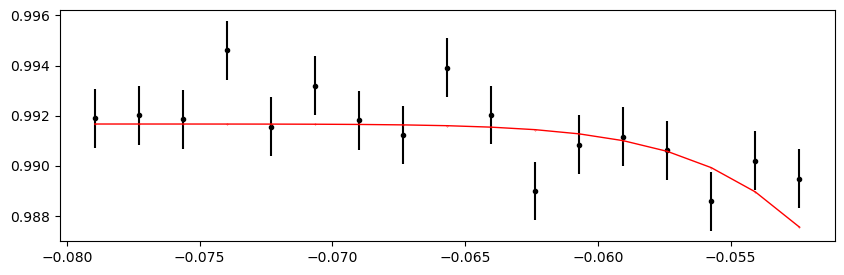

2315.2994 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.40it/s]


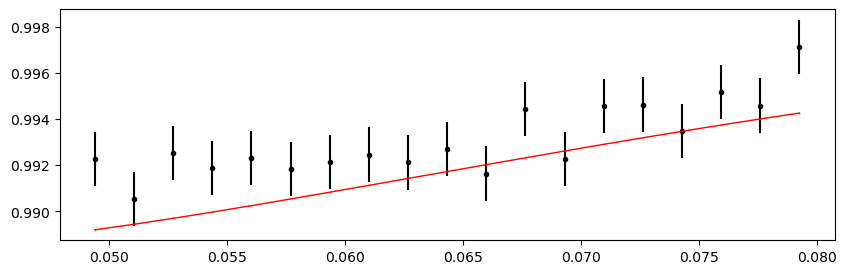

2316.1366449999996 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.69it/s]


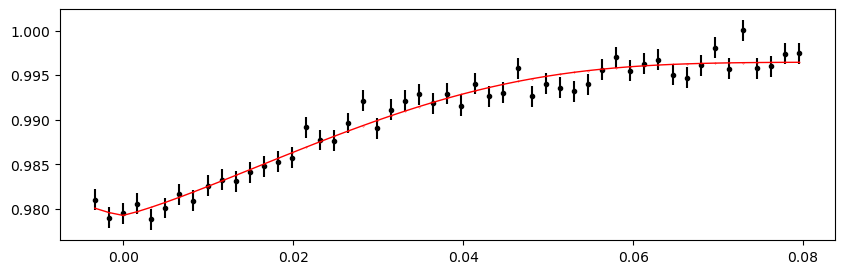

2316.9738899999998 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.91it/s]


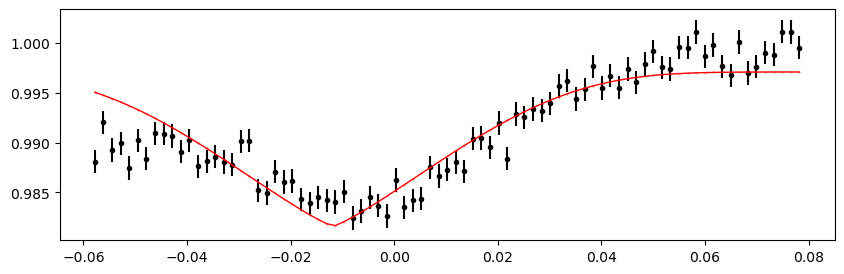

2317.811135 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.68it/s]


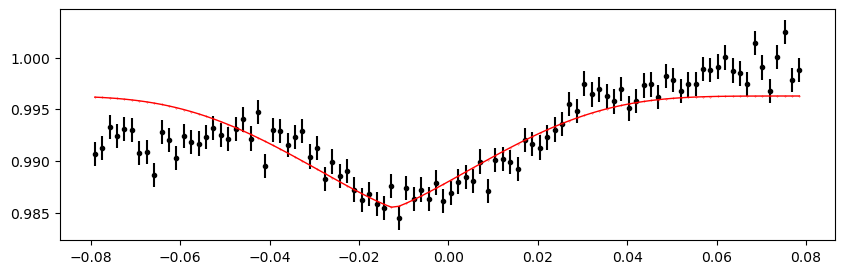

2318.6483799999996 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.92it/s]


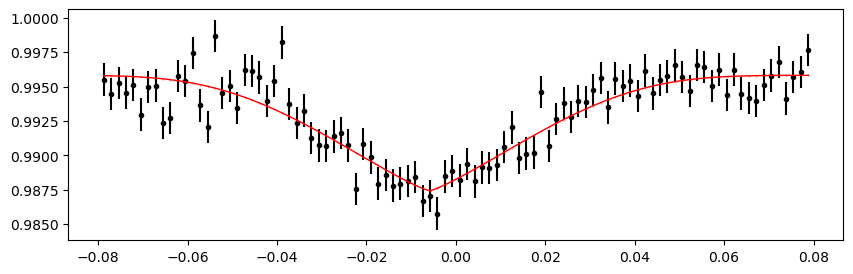

2322.834605 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.89it/s]


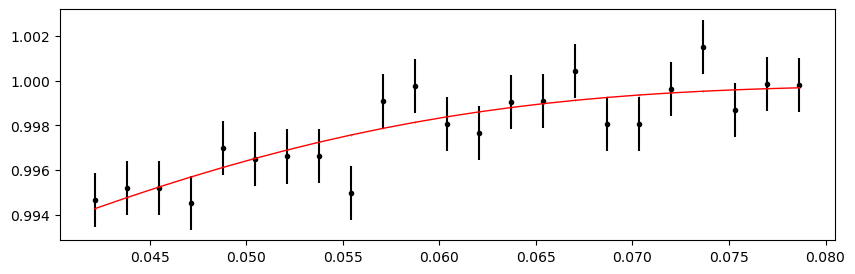

2323.6718499999997 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.15it/s]


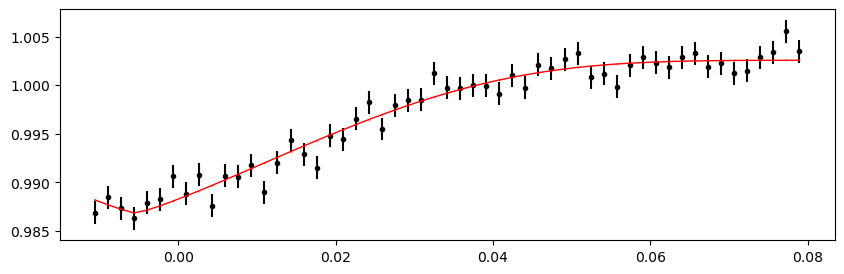

2324.509095 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.19it/s]


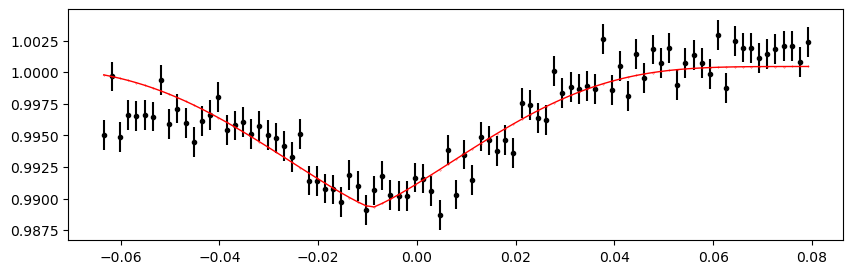

2325.34634 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.81it/s]


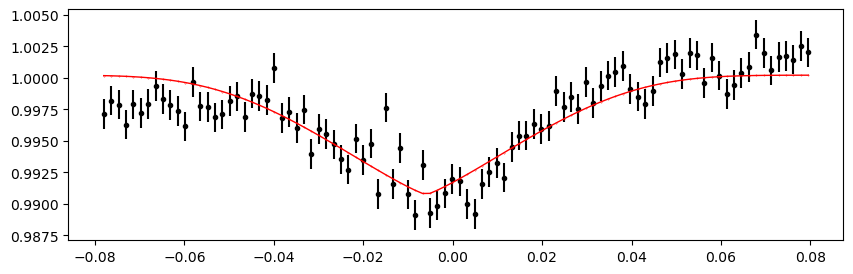

2326.1835849999998 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.79it/s]


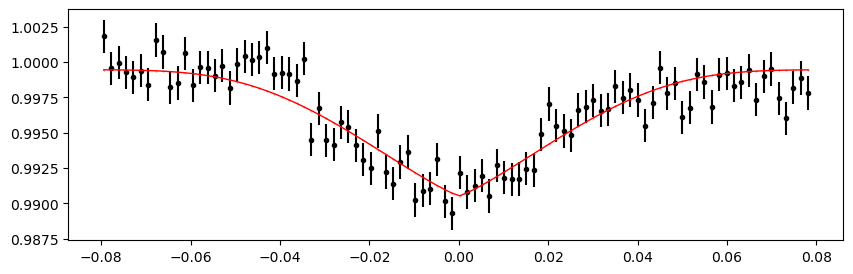

2327.02083 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.63it/s]


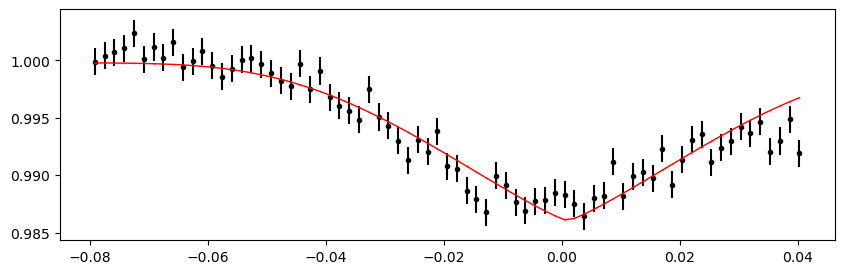

2327.858075 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.81it/s]


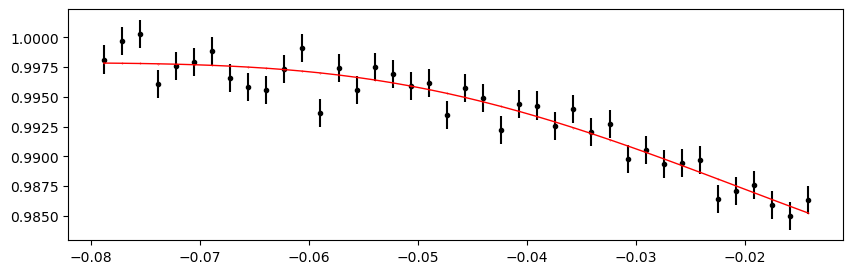

2328.69532 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 543.29it/s]


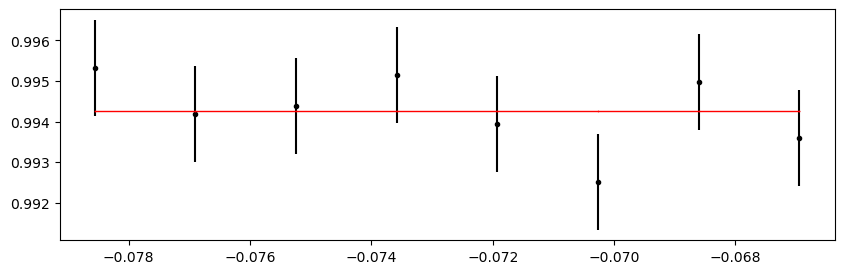

2330.3698099999997 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.69it/s]


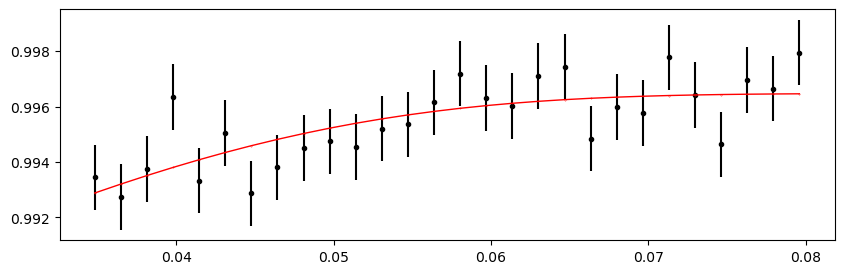

2331.207055 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.07it/s]


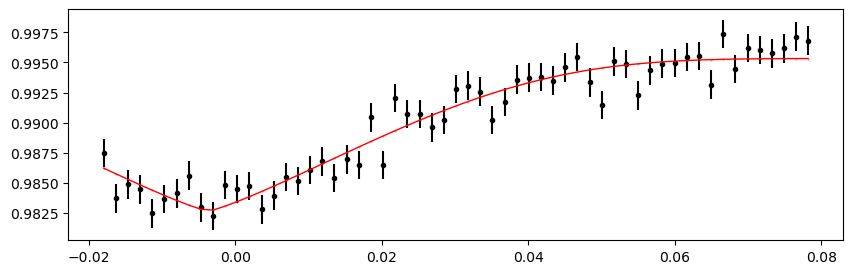

2332.0442999999996 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.68it/s]


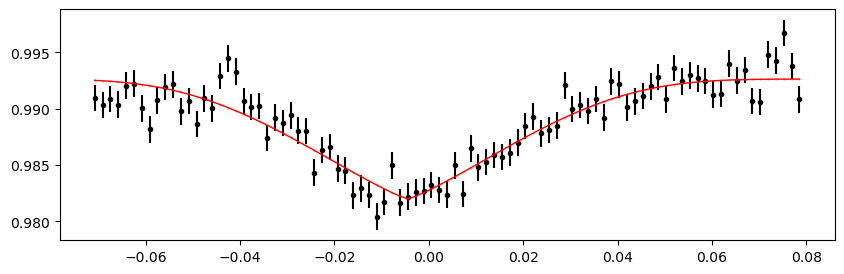

3041.190815 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.88it/s]


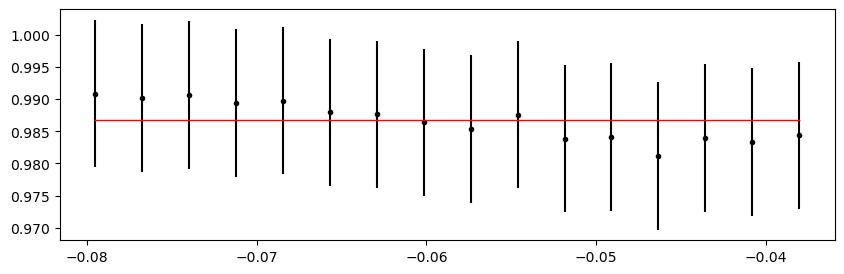

3042.865305 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 482.26it/s]


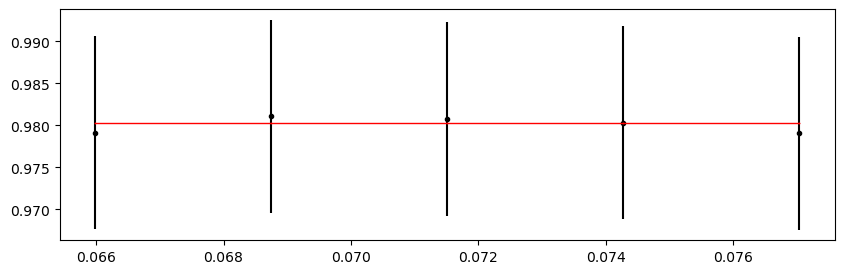

3043.70255 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.88it/s]


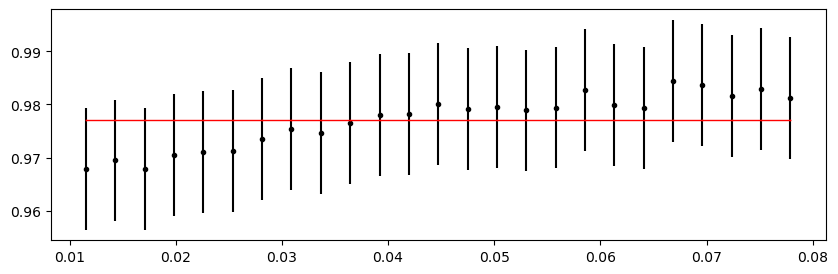

3044.5397949999997 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.81it/s]


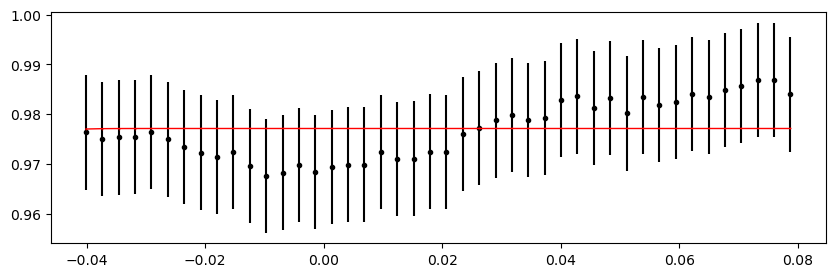

3045.37704 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.39it/s]


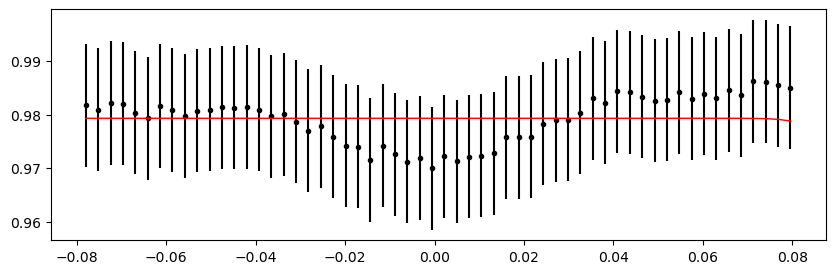

3046.214285 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 490.26it/s]


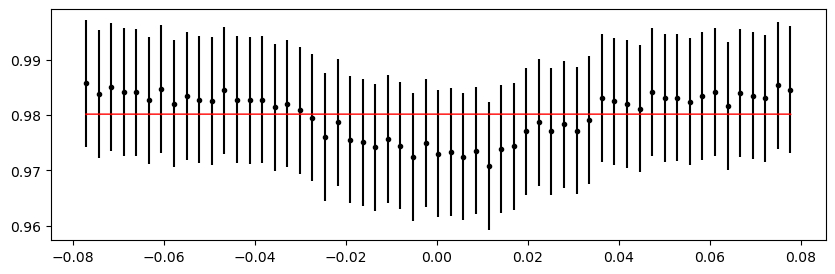

3047.0515299999997 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 482.00it/s]


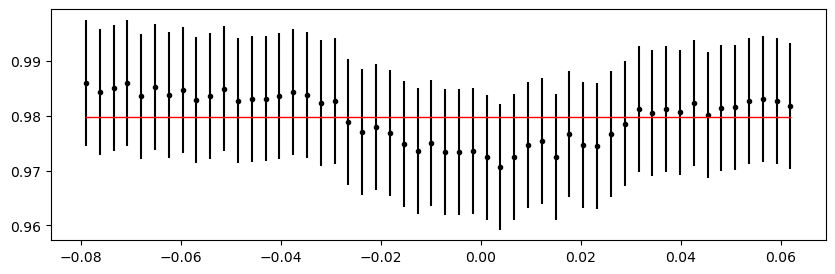

3047.888775 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 477.43it/s]


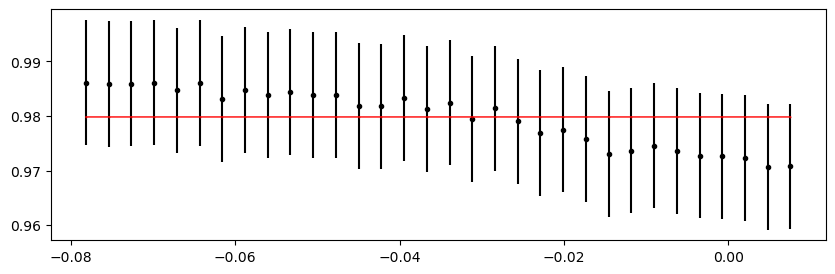

3048.72602 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 498.00it/s]


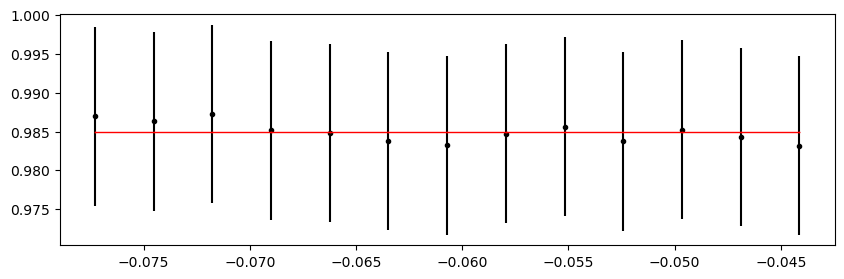

3050.40051 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 488.63it/s]


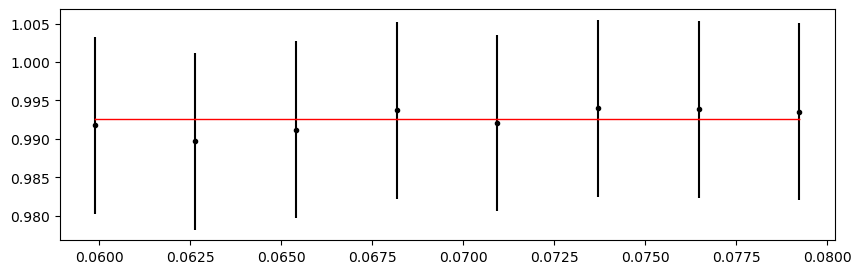

3051.237755 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 472.74it/s]


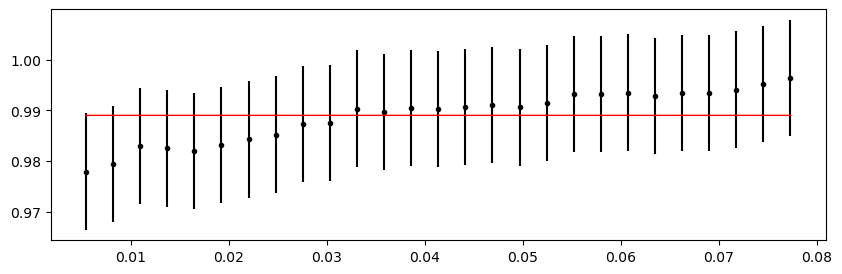

3052.075 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 467.29it/s]


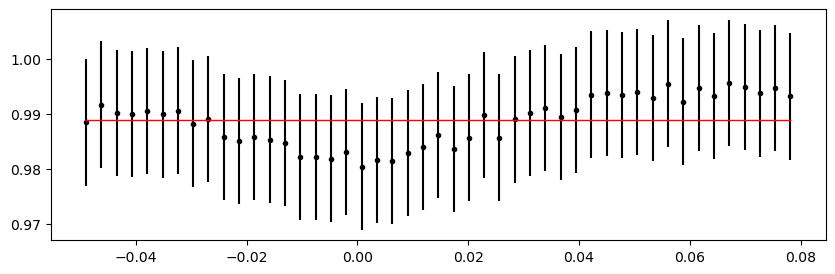

3052.9122449999995 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.33it/s]


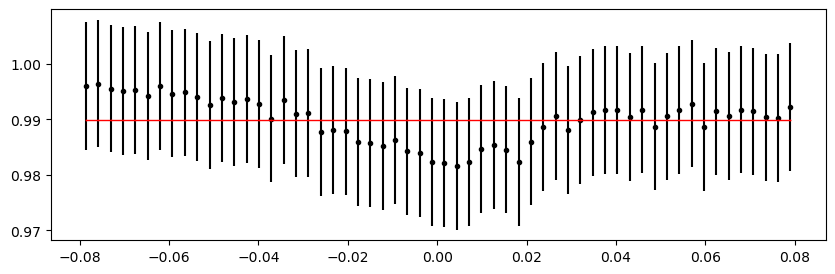

3053.74949 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 468.69it/s]


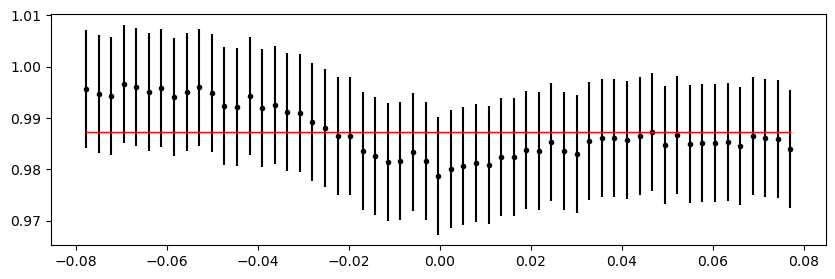

3054.586735 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 477.17it/s]


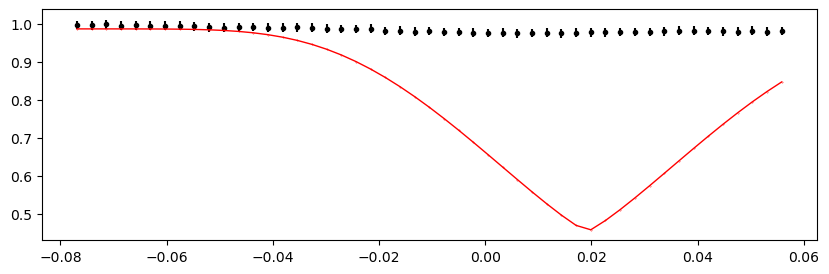

3055.4239799999996 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 496.48it/s]


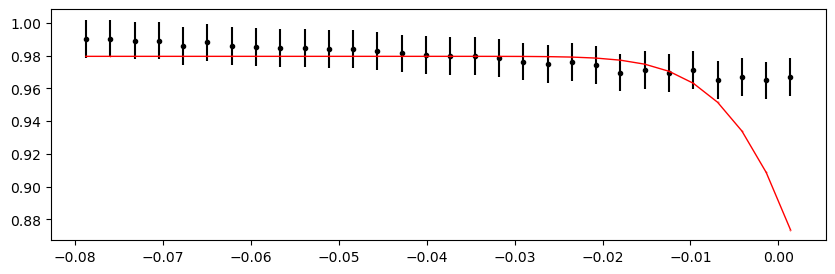

3056.2612249999997 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 499.22it/s]


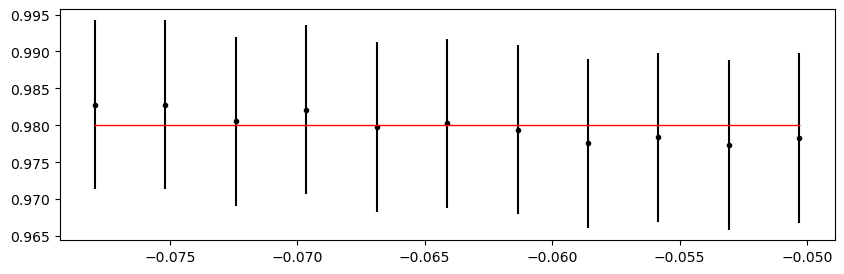

3057.9357149999996 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 477.95it/s]


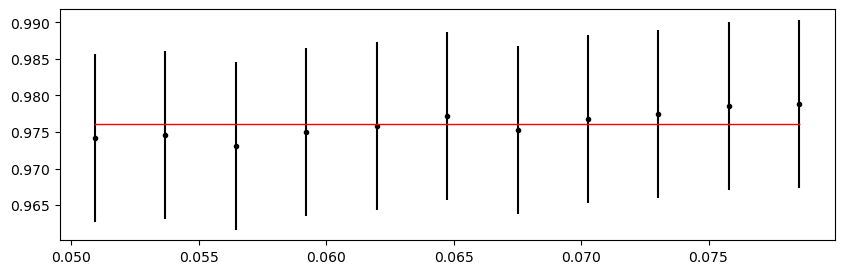

3058.77296 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 488.08it/s]


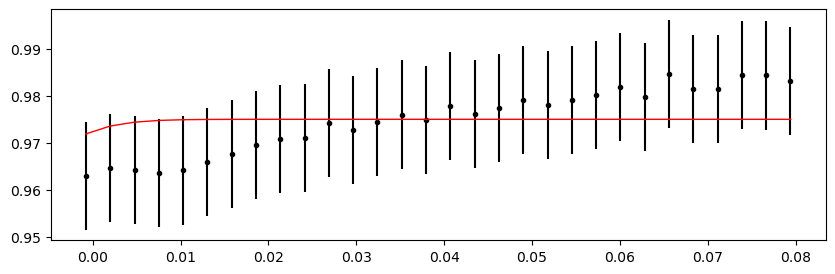

3059.610205 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 492.35it/s]


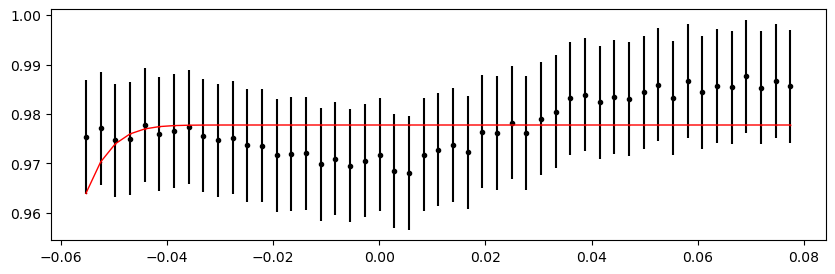

3060.4474499999997 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 493.65it/s]


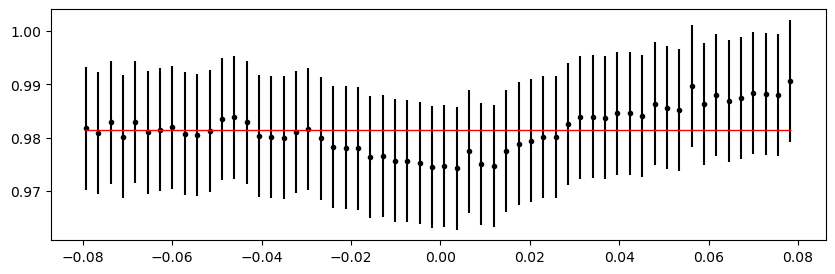

3061.284695 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 487.03it/s]


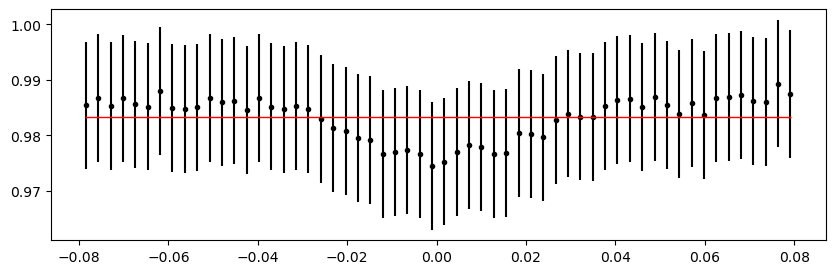

3062.12194 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 493.07it/s]


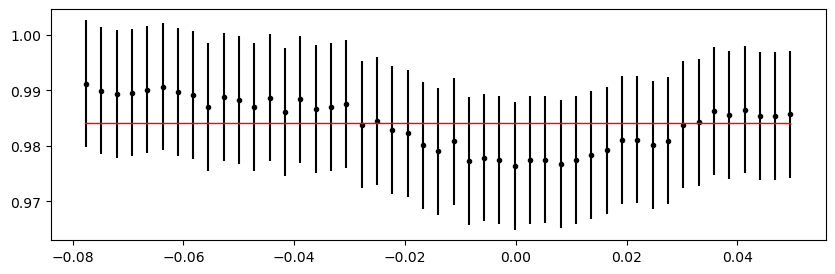

3062.9591849999997 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 487.51it/s]


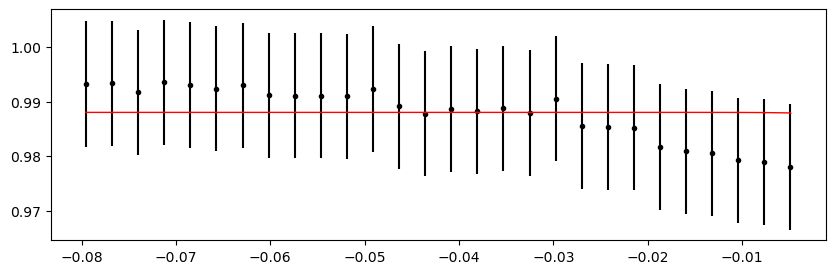

3063.79643 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 465.61it/s]


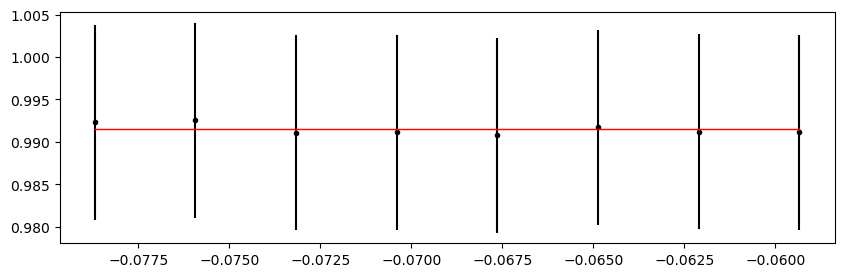

3065.4709199999998 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.00it/s]


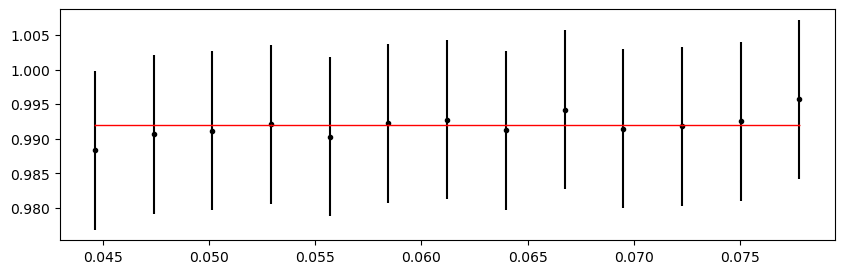

3066.308165 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.83it/s]


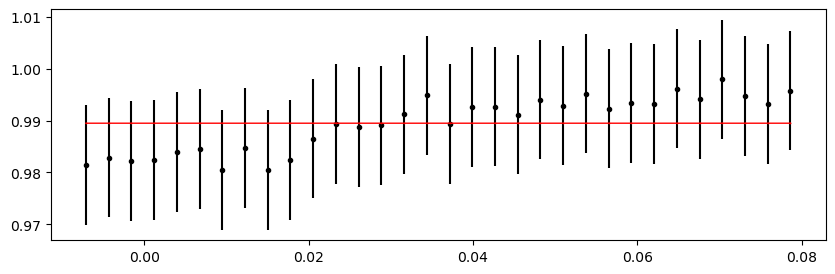

3067.14541 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 485.75it/s]


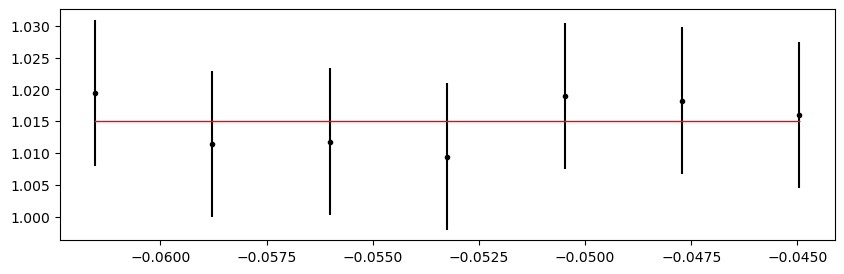

3067.982655 0.9970137121977671 -0.011523940735898013 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 487.62it/s]


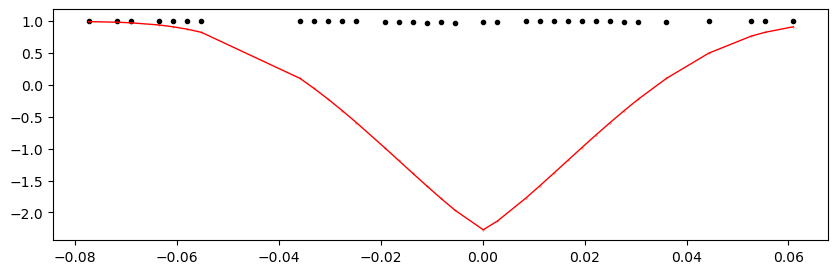

In [47]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=2,  # for 30 min cadence data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


Fitting individual secondary eclipses...
Creating new manifest file
Time 1572.2444624999996 does not have enough data points: 1
1573.0817074999998 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 501.88it/s]


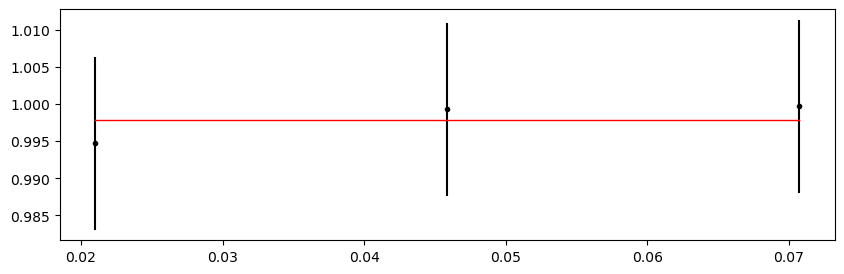

1573.9189524999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 483.17it/s]


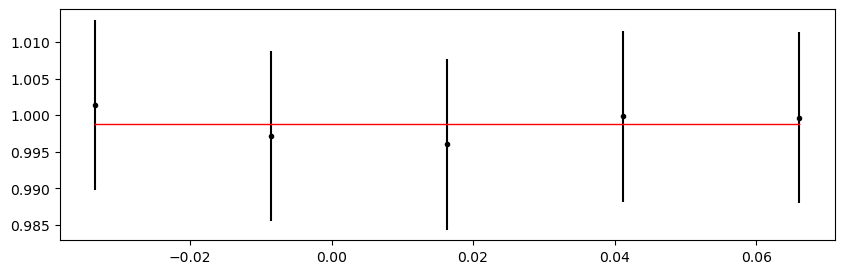

1574.7561974999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 474.90it/s]


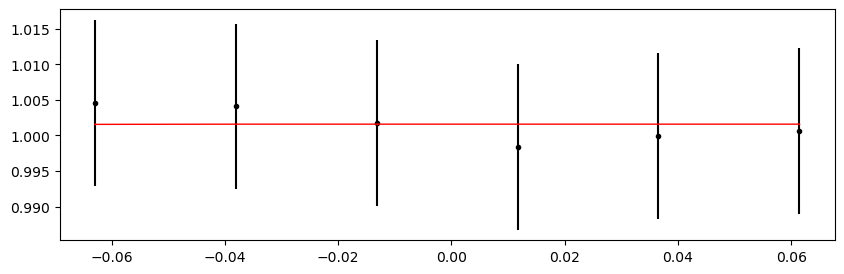

1575.5934424999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 490.82it/s]


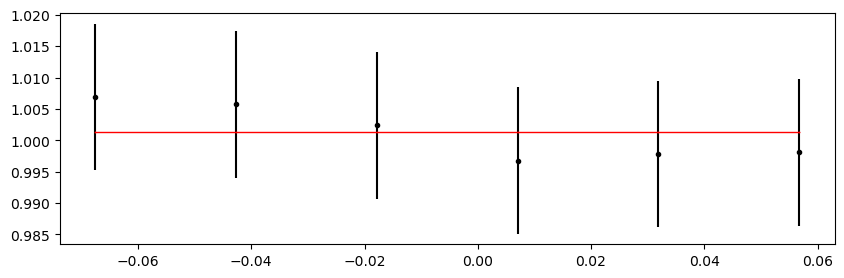

1576.4306874999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.57it/s]


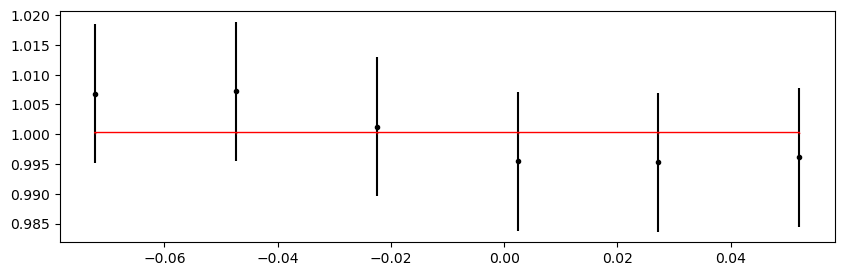

1577.2679324999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.38it/s]


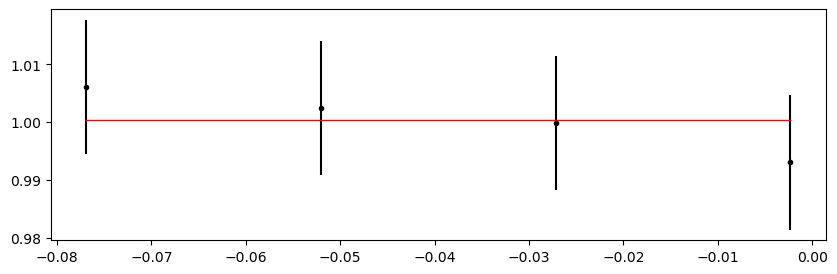

Time 1578.1051774999996 does not have enough data points: 1
1580.6169124999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 514.79it/s]


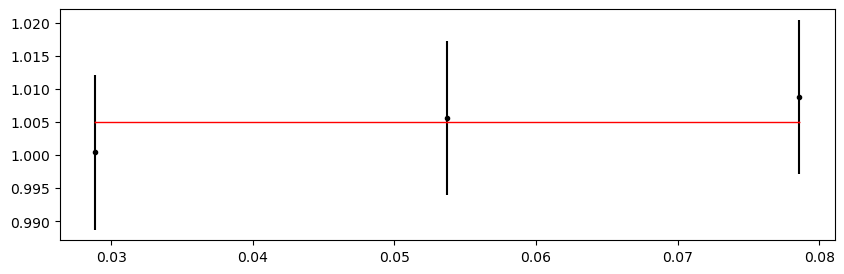

1581.4541574999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 496.28it/s]


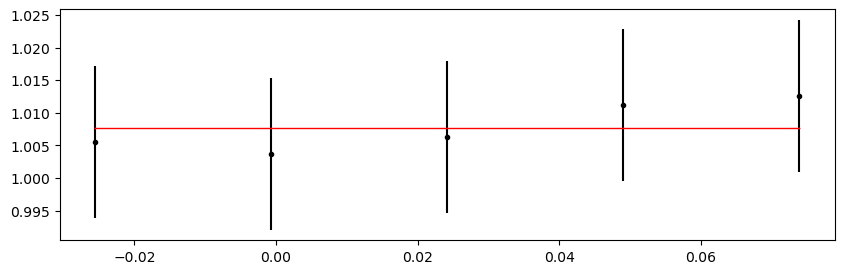

1583.1286474999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 468.36it/s]


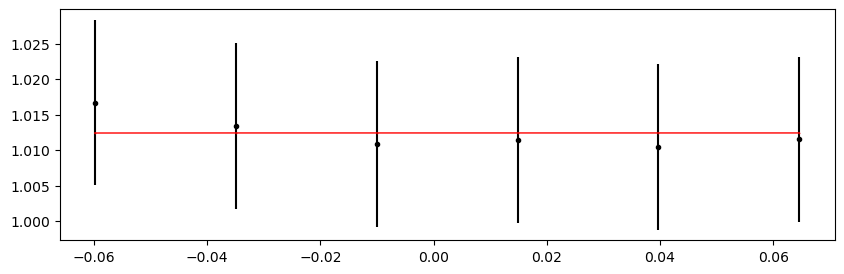

1584.8031374999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 493.39it/s]


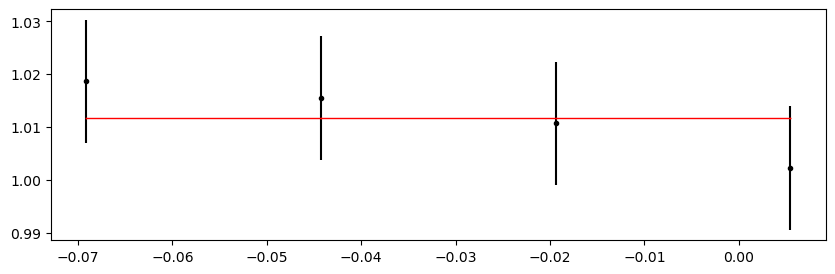

Time 1585.6403824999998 does not have enough data points: 2
Time 1587.3148724999996 does not have enough data points: 1
1588.1521174999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 478.39it/s]


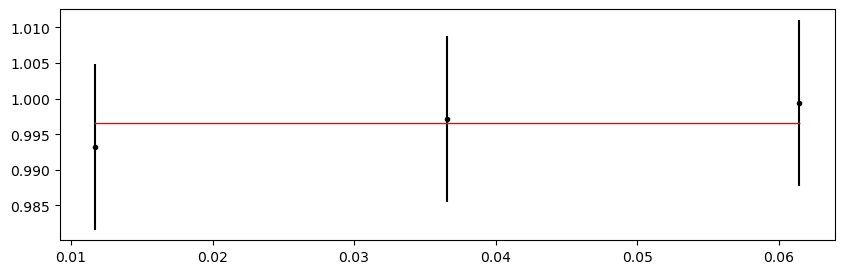

1588.9893624999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.27it/s]


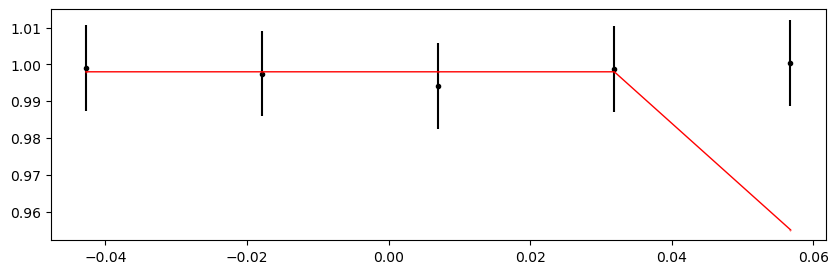

1589.8266074999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.77it/s]


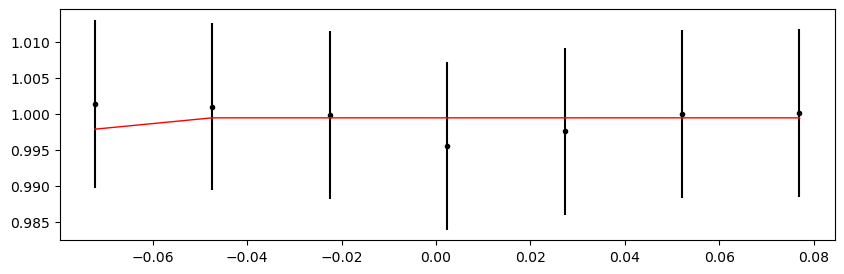

1590.6638524999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 464.34it/s]


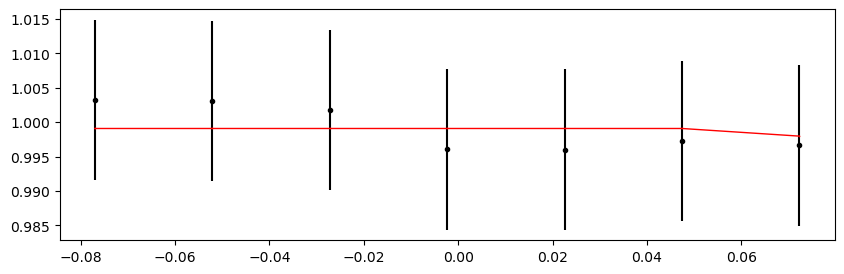

1591.5010974999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 493.80it/s]


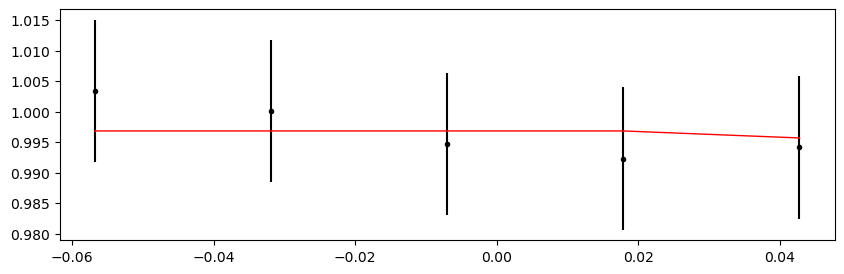

1592.3383424999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 488.12it/s]


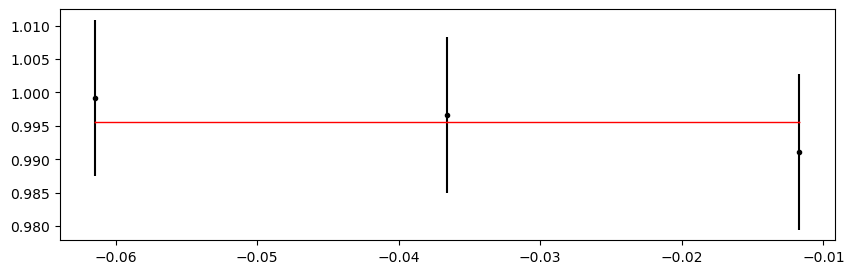

Time 1593.1755874999997 does not have enough data points: 1
Time 1594.8500774999998 does not have enough data points: 1
2309.8573074999995 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 357.34it/s]


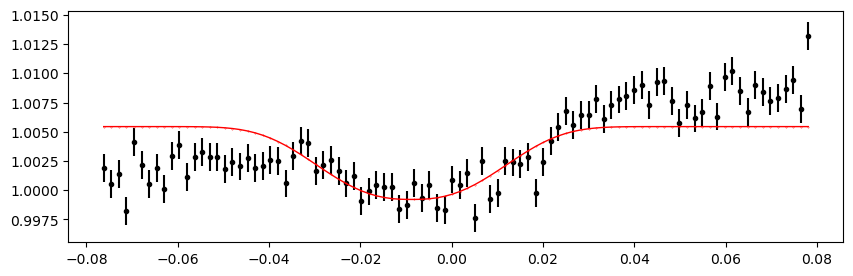

2310.6945524999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.97it/s]


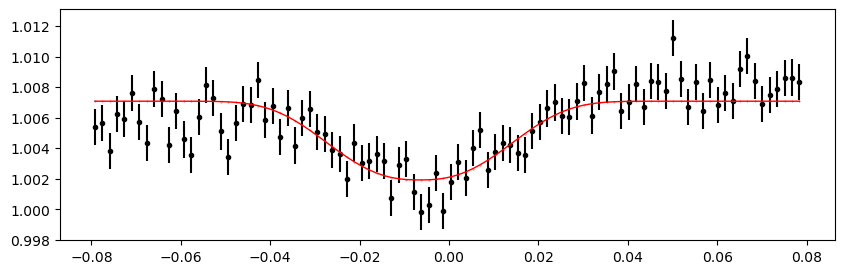

2311.5317975 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.93it/s]


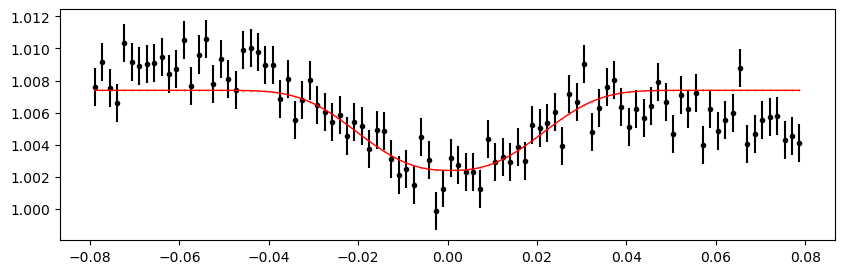

2312.3690424999995 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.51it/s]


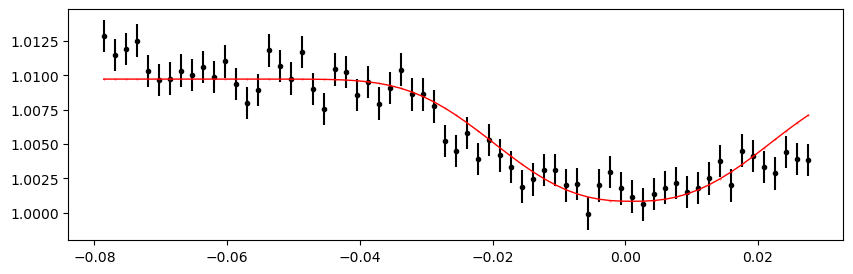

2313.2062874999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.33it/s]


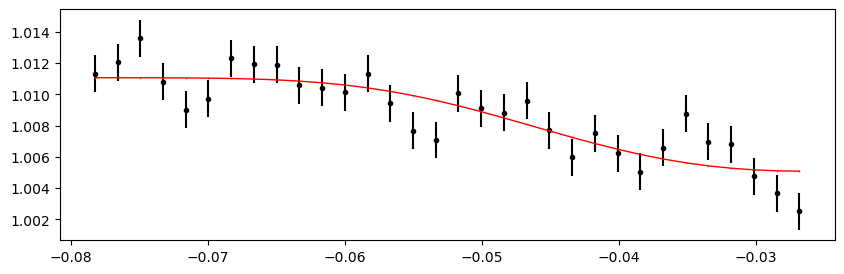

Time 2314.0435325 does not have enough data points: 1
Time 2314.8807774999996 does not have enough data points: 2
2315.7180224999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.47it/s]


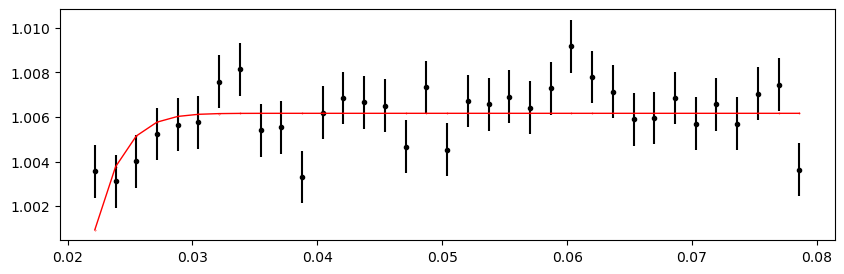

2316.5552675 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 368.21it/s]


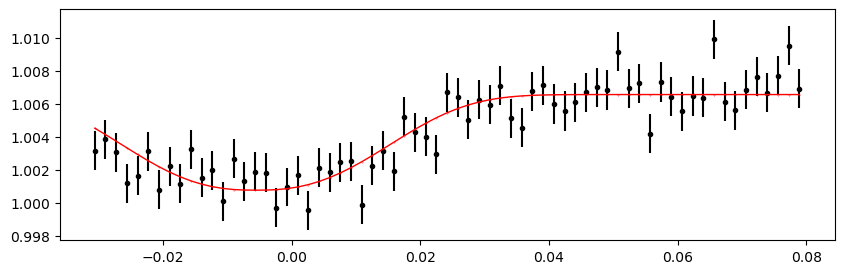

2317.3925124999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 353.01it/s]


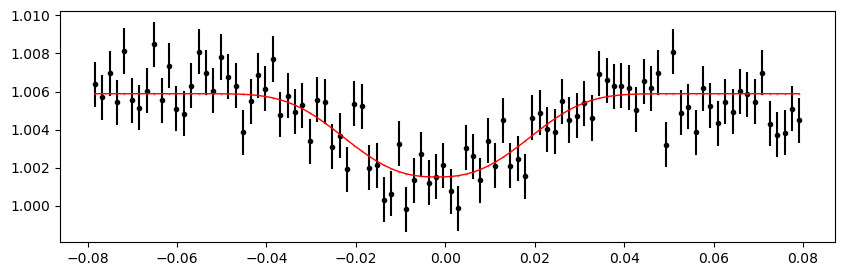

2318.2297575 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.04it/s]


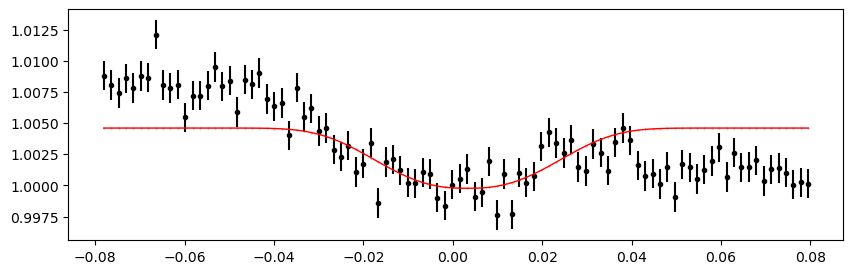

2319.0670025 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.50it/s]


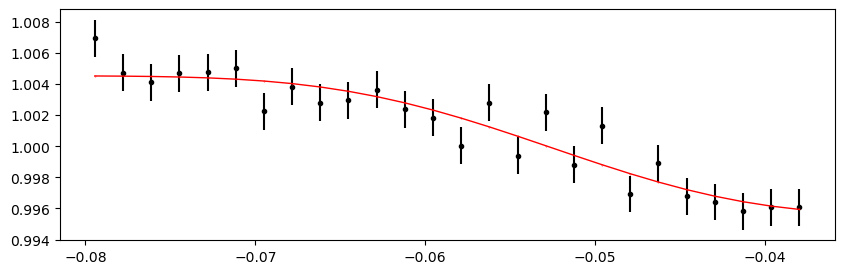

2322.4159824999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 496.15it/s]


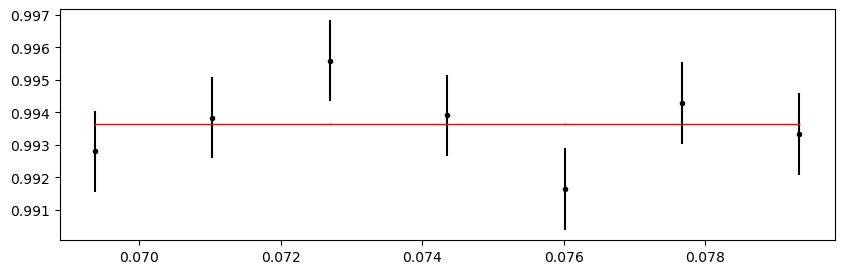

2323.2532274999994 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.80it/s]


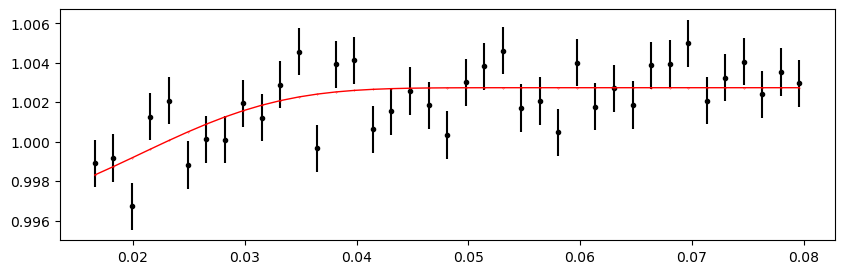

2324.0904724999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 351.33it/s]


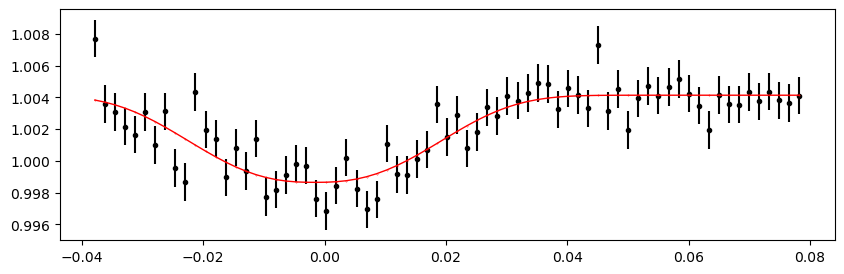

2324.9277174999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 351.56it/s]


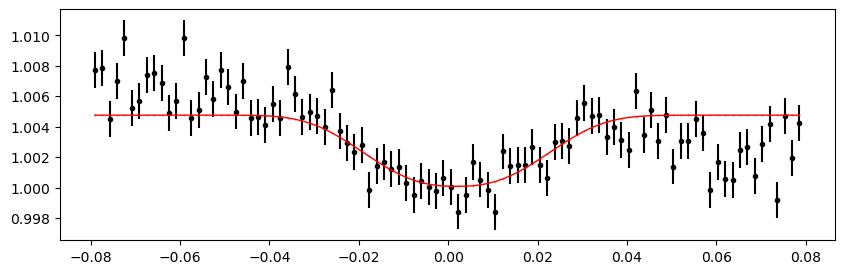

2325.7649624999995 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.44it/s]


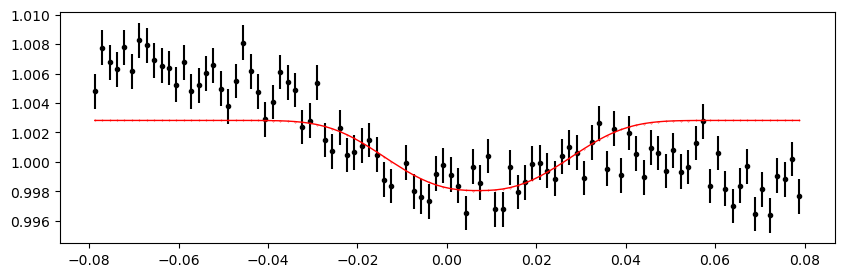

2326.6022074999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.26it/s]


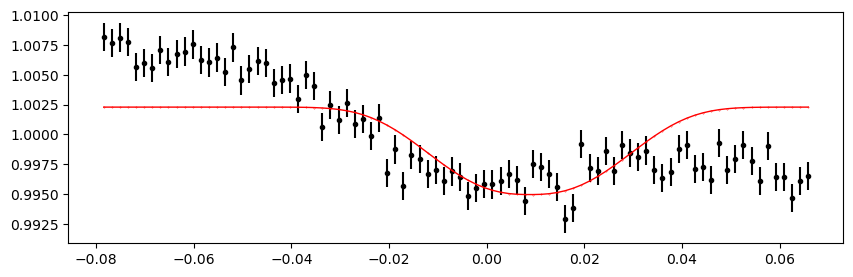

2327.4394525 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.38it/s]


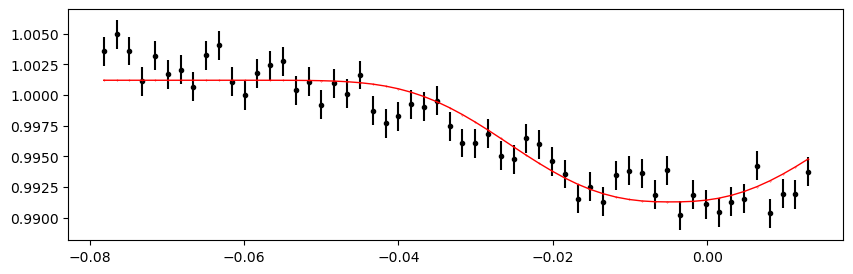

2328.2766974999995 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.90it/s]


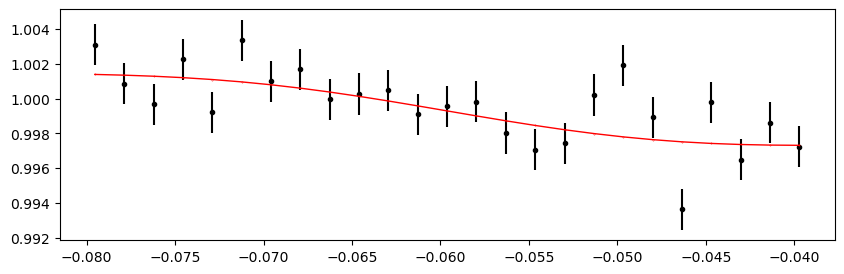

2329.9511875 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 468.63it/s]


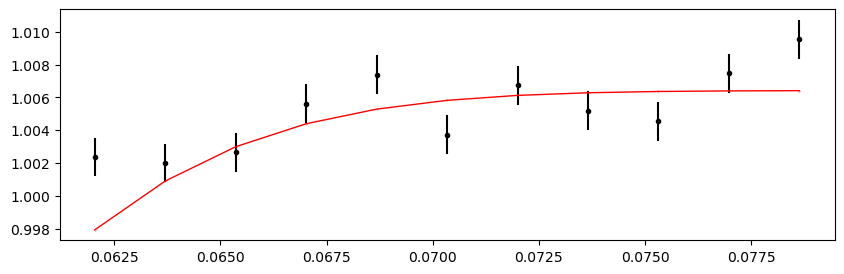

2330.7884324999995 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.85it/s]


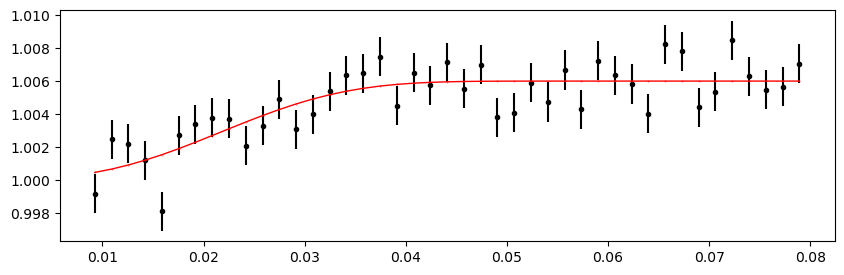

2331.6256774999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.48it/s]


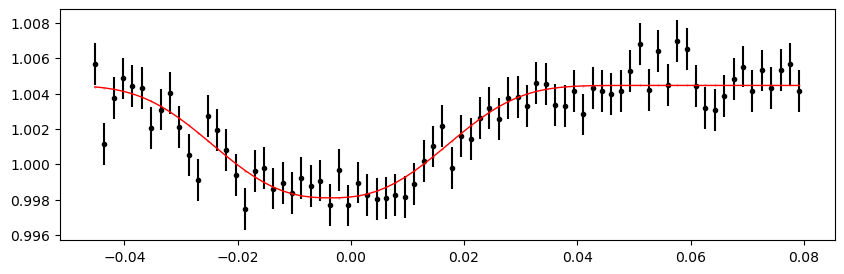

2332.4629225 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.64it/s]


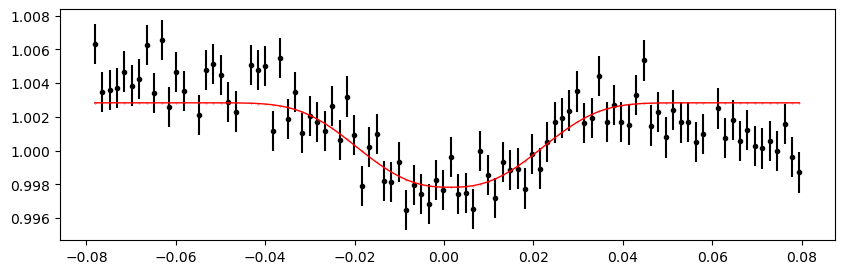

3041.6094375 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 501.12it/s]


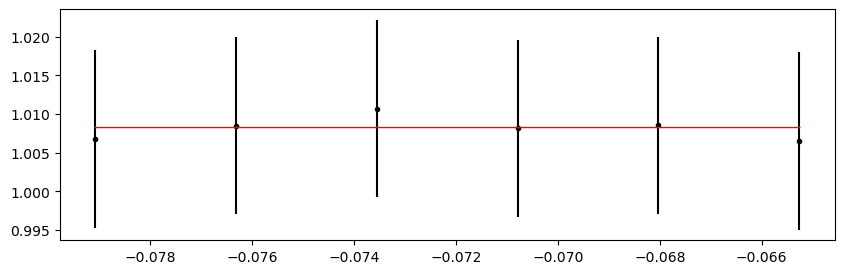

3043.2839274999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 503.33it/s]


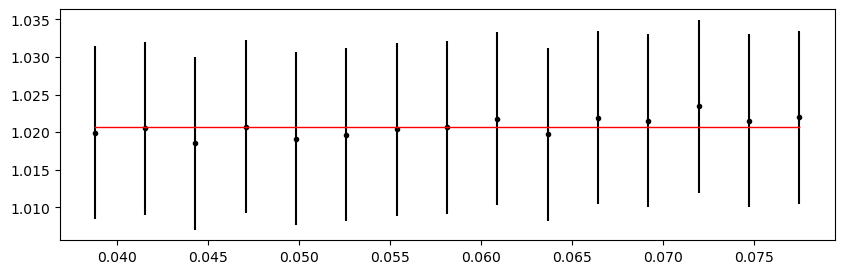

3044.1211724999994 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 479.95it/s]


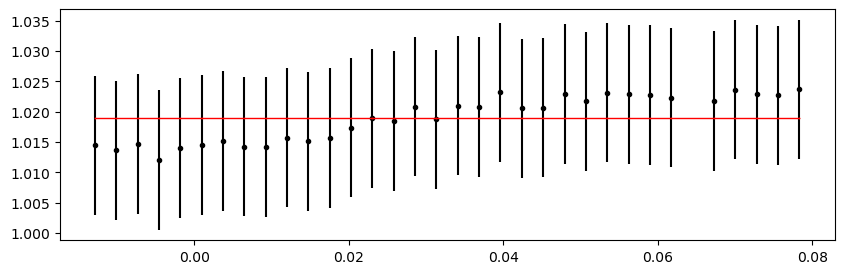

3044.9584175 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 485.04it/s]


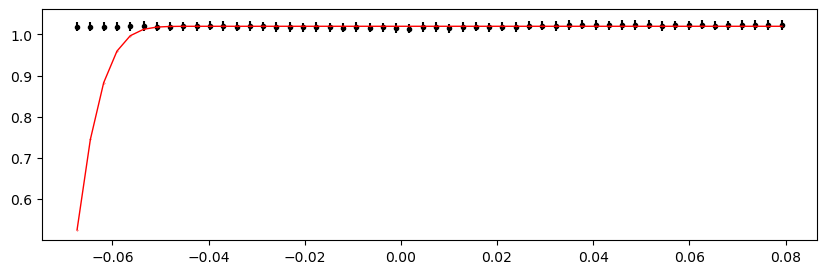

3045.7956624999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 458.77it/s]


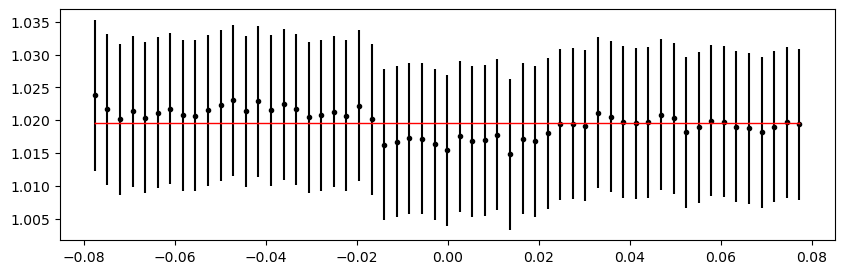

3046.6329074999994 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 435.76it/s]


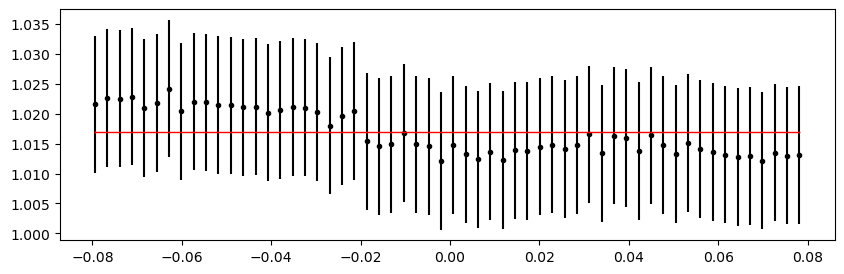

3047.4701524999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.64it/s]


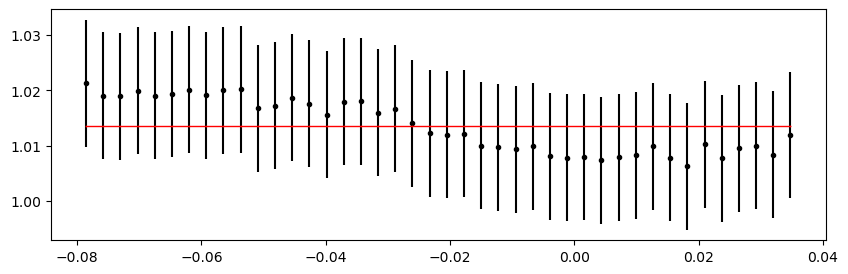

3049.1446424999995 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 503.15it/s]


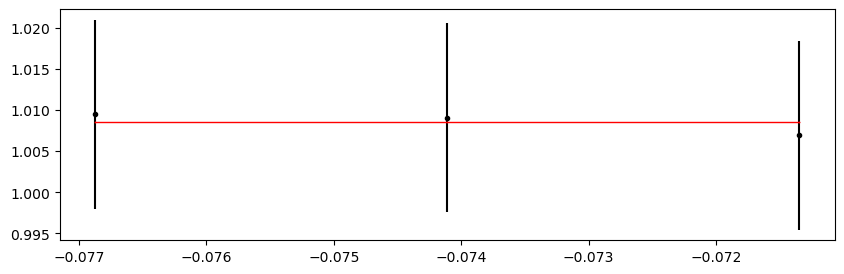

3050.8191325 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 469.77it/s]


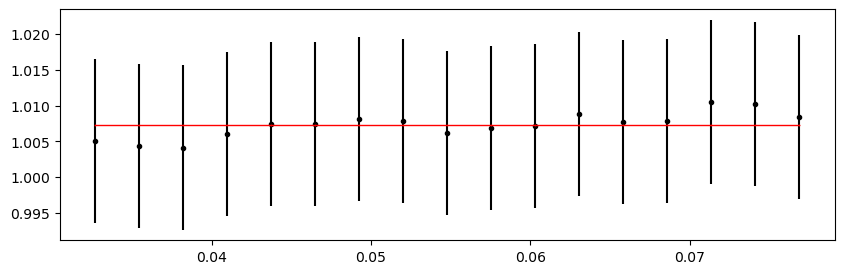

3051.6563774999995 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 477.86it/s]


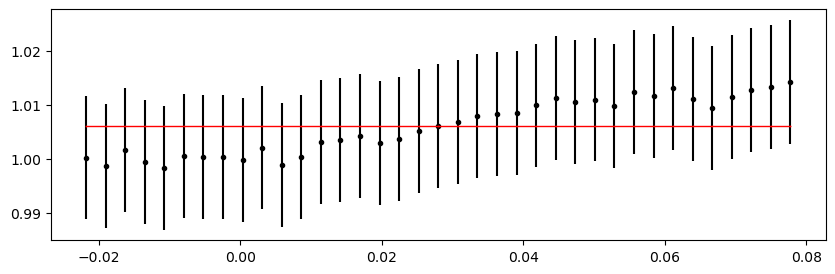

3052.4936224999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 454.38it/s]


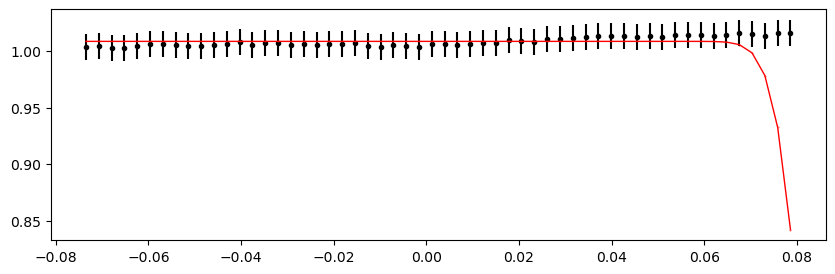

3053.3308675 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 463.27it/s]


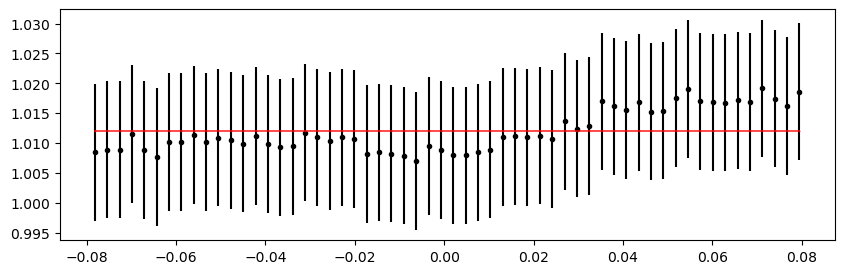

3054.1681124999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.50it/s]


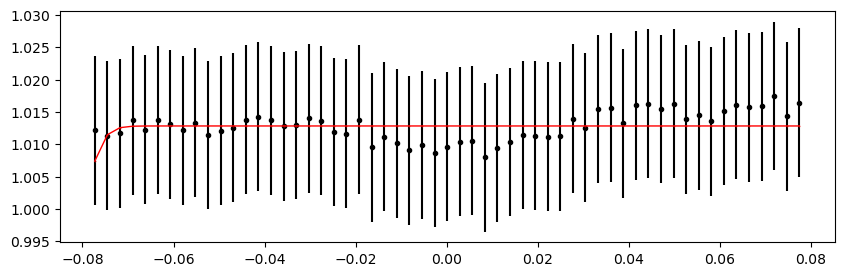

3055.0053574999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 466.40it/s]


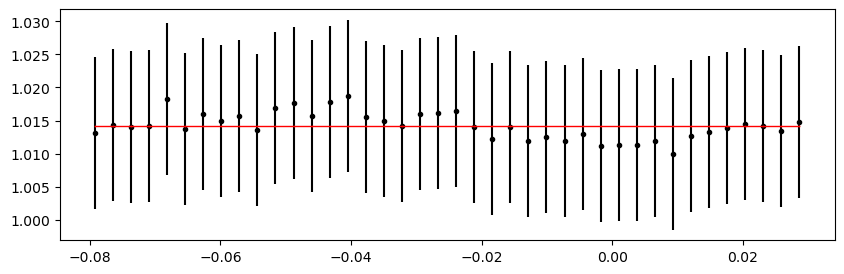

3055.8426025 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 500.49it/s]


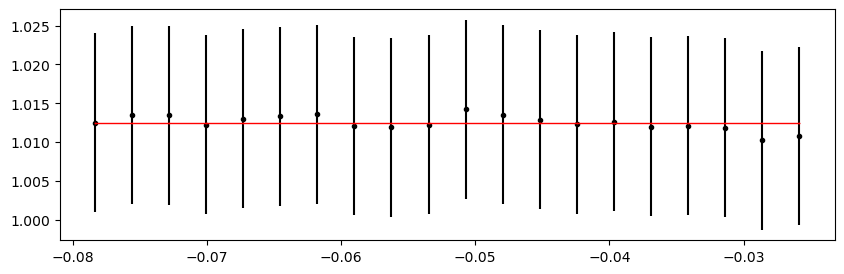

Time 3056.6798474999996 does not have enough data points: 1
Time 3057.5170924999998 does not have enough data points: 1
3058.3543375 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 496.75it/s]


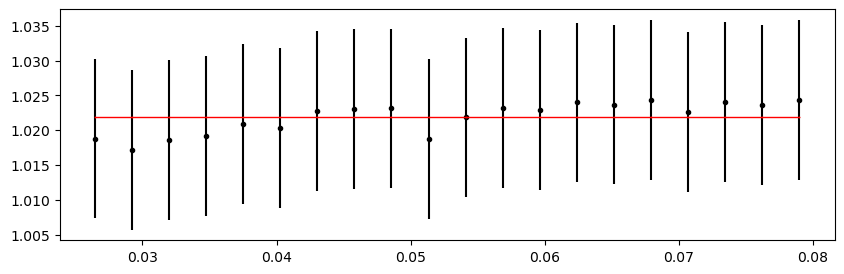

3059.1915824999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 494.50it/s]


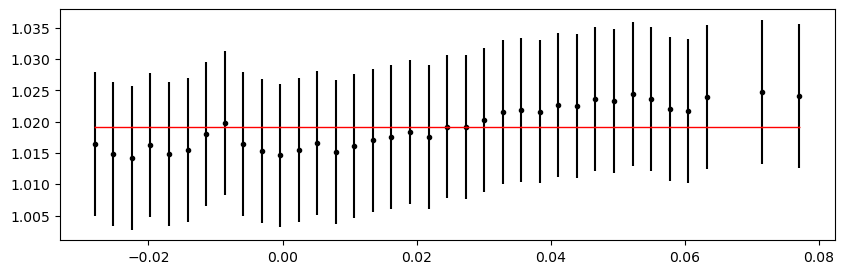

3060.0288274999994 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 459.66it/s]


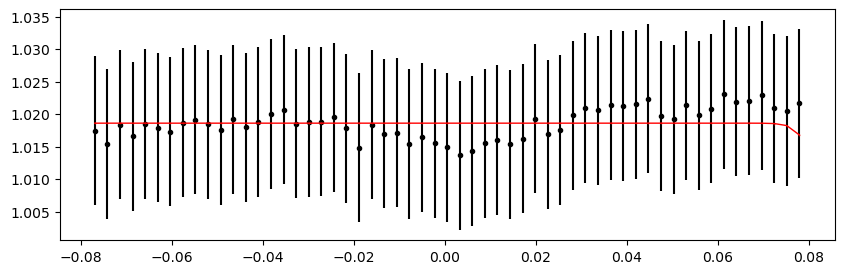

3060.8660725 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.68it/s]


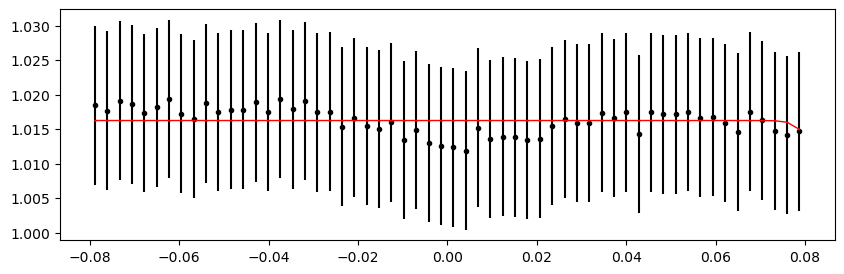

3061.7033174999997 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 454.21it/s]


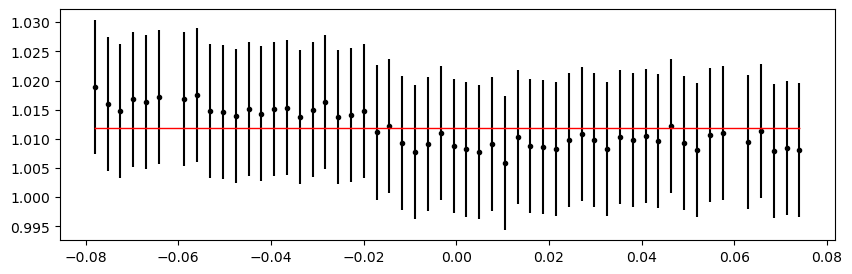

3062.5405624999994 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 468.11it/s]


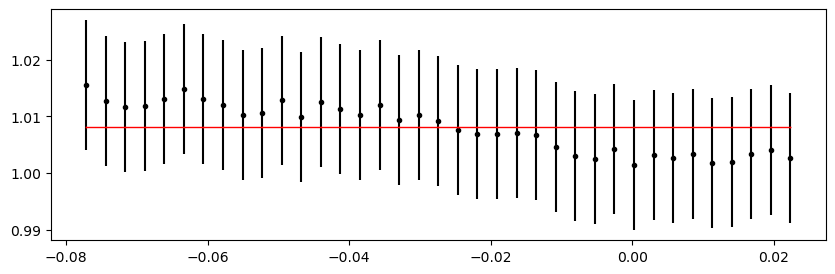

3063.3778075 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 463.18it/s]


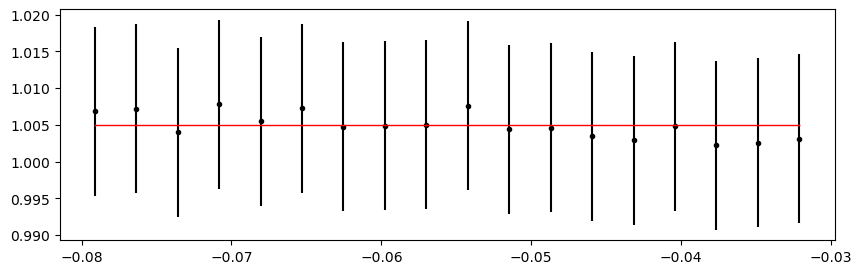

3065.0522974999994 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 492.06it/s]


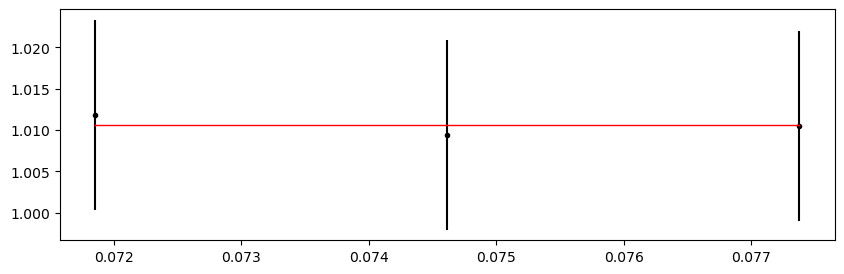

3065.8895424999996 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 488.51it/s]


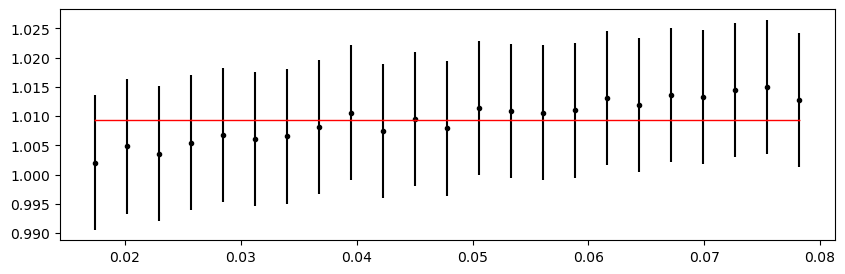

3066.7267875 1.0047948336711348 -0.005532378302619059 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 488.84it/s]


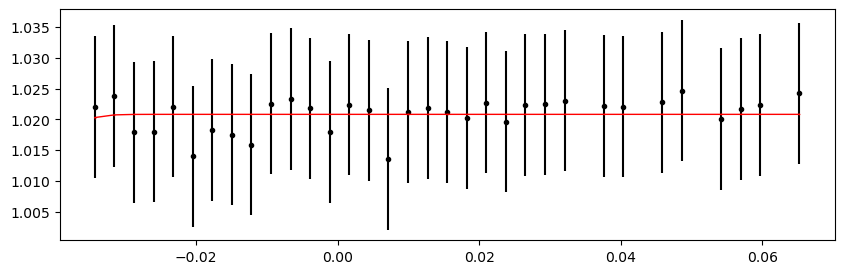

In [61]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=2,  # for 30 min cadence data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

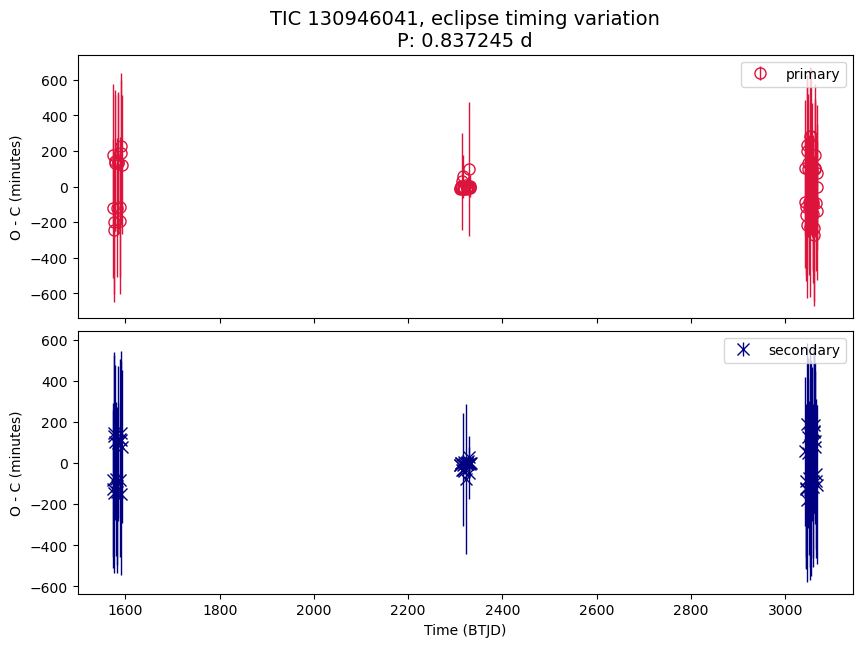

In [62]:
%matplotlib inline
# %matplotlib widget
# plt.close()
    
title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

# in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
# print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    # in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    # print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

### O-C Plot, Zoom In

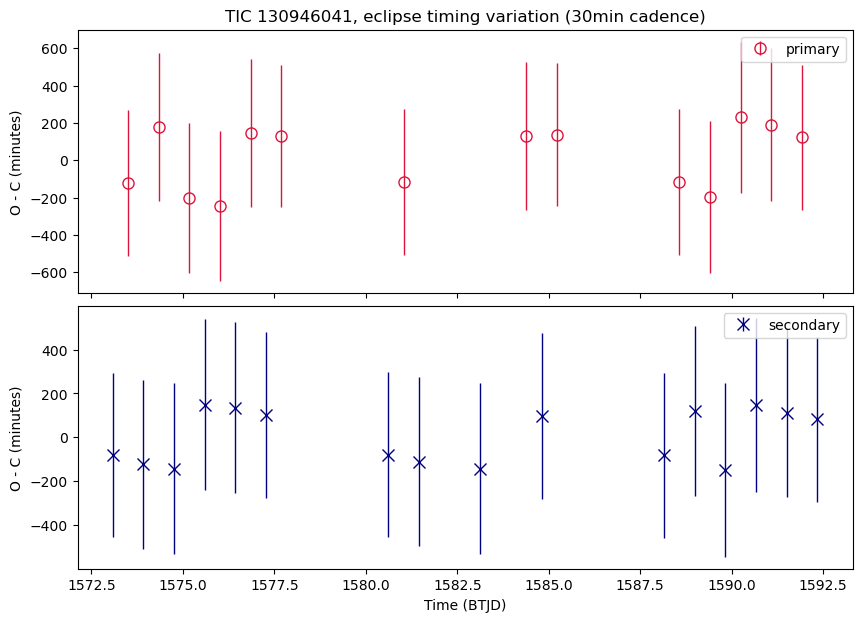

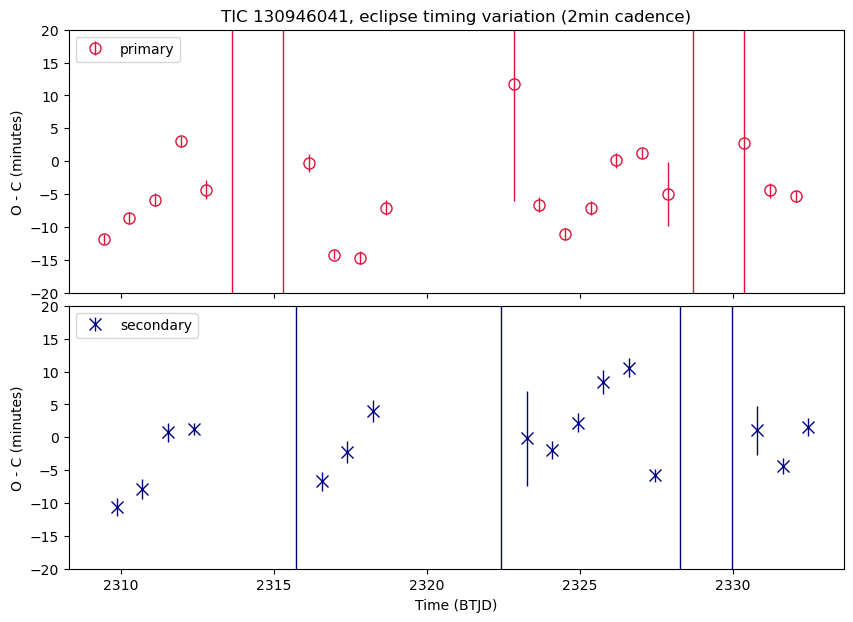

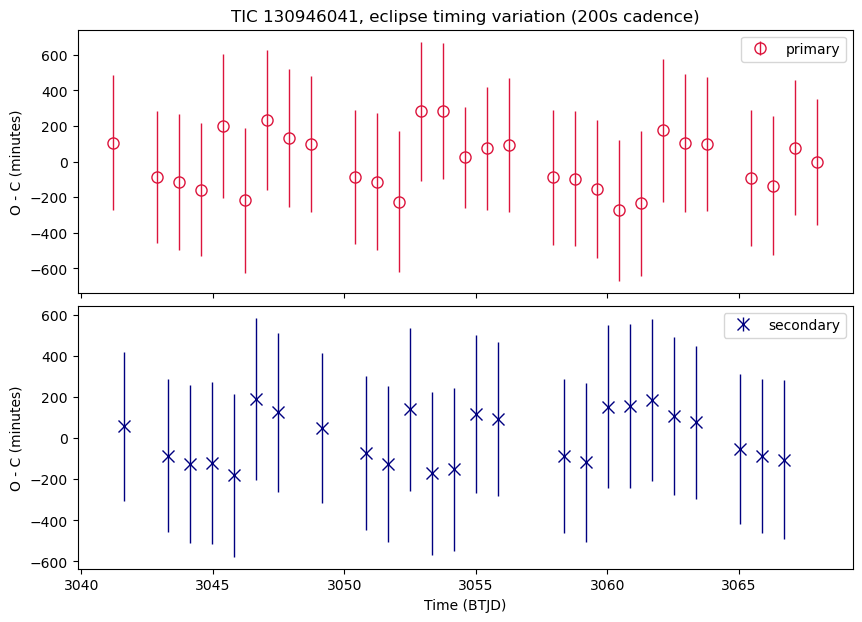

In [69]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1500, 1700),
    (2200, 2400),
    (3000, 3200),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    ax = axs_list[0][0]
    ax.set_title(f"{ax.get_title()} (30min cadence)")
    
    ax = axs_list[1][0]
    ax.set_title(f"{ax.get_title()} (2min cadence)")
    ax.set_ylim(-20, 20)
    axs_list[1][1].set_ylim(-20, 20)
    
    ax = axs_list[2][0]
    ax.set_title(f"{ax.get_title()} (200s cadence)")

    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

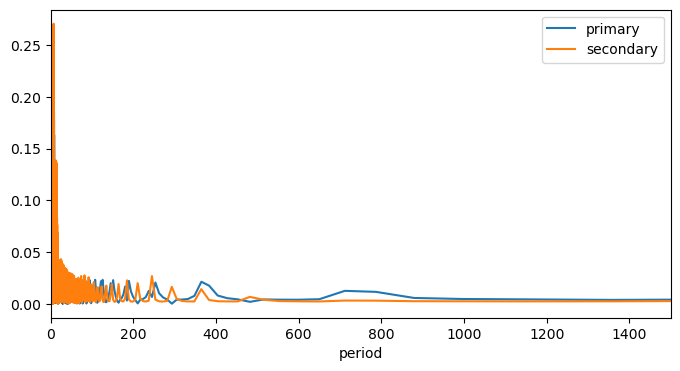

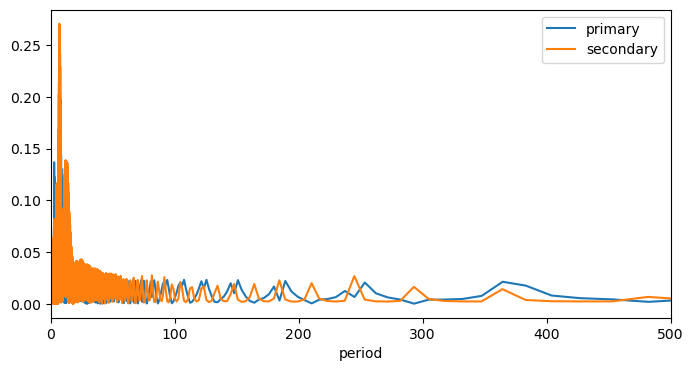

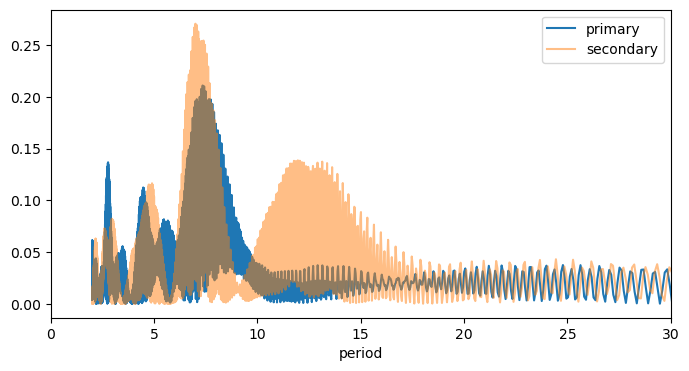

In [88]:
# set maximum_frequency so that it'll consider shorter periods (roughly < 9 d) excluded by the default grid
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower(maximum_frequency=1 / 2)  # i.e. min period >= 2 d

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower(maximum_frequency=1 / 2)
    plt.plot(1/frequency_s, power_s, label = 'secondary')

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1500)
plt.show()

if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 500)
    plt.show()
    
if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, alpha=0.5, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 30)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [72]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

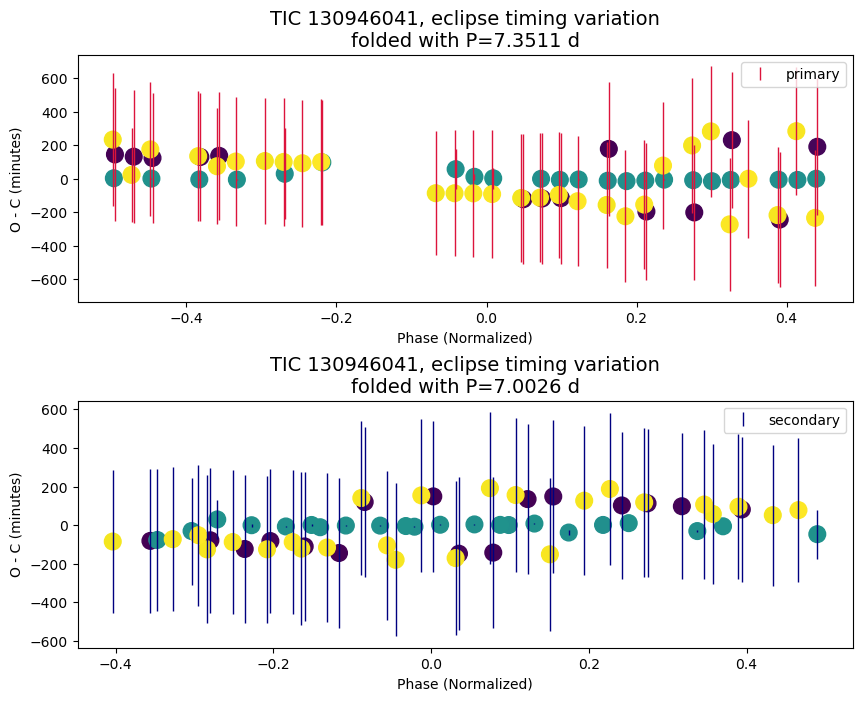

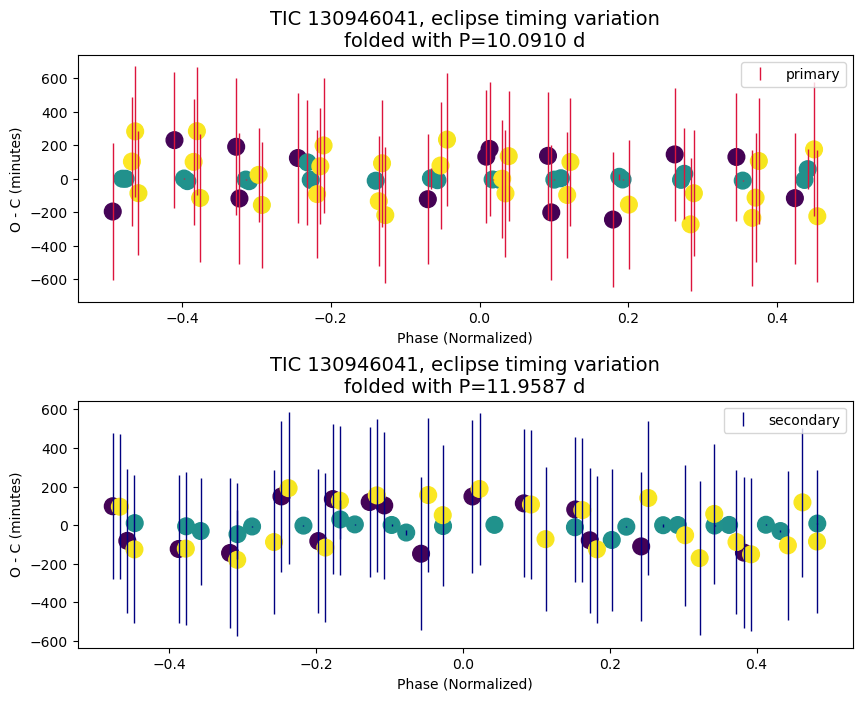

In [90]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=None,
        period_min_s=None, period_max_s=None
    )
    
    axs = plot_oc_folded(
        period_min=10, period_max=None,
        period_min_s=10, period_max_s=None
    )

    tweak_axs(axs)

## Run custom indiviual fit (per-sector for sector 10)

- sector 10 (30 min cadence data) O-C is highly uncertain: per-eclipse data is too sparse. Get an idea of the average of the entire sector.
- Result is not better

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [02:15<00:00, 22.07it/s]
The chain is shorter than 20 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 150;
tau: [150.25497432 147.21099745 102.19523178 131.03448767 165.31463236]


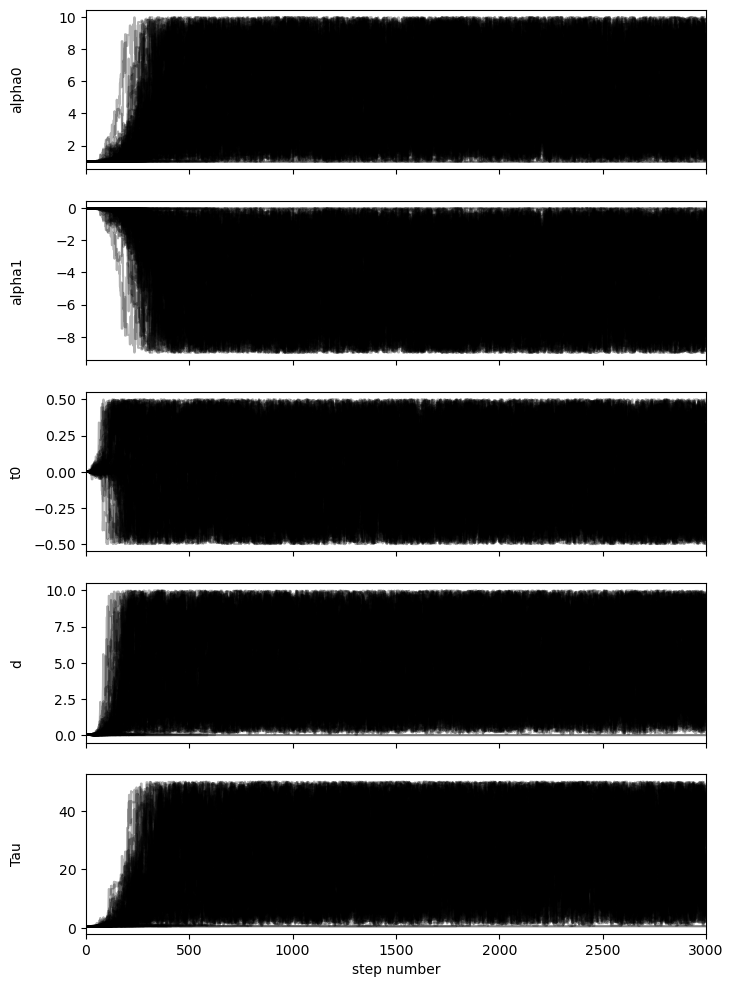

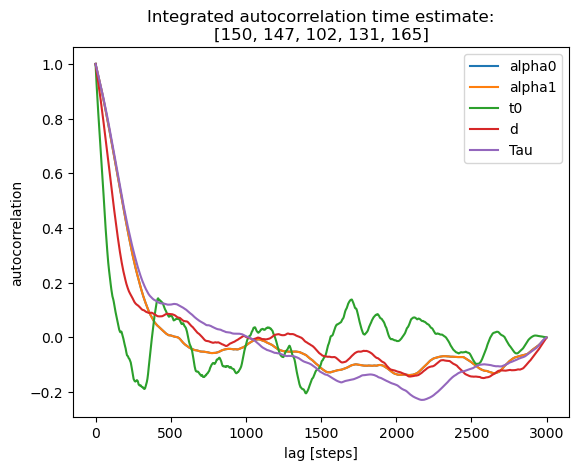

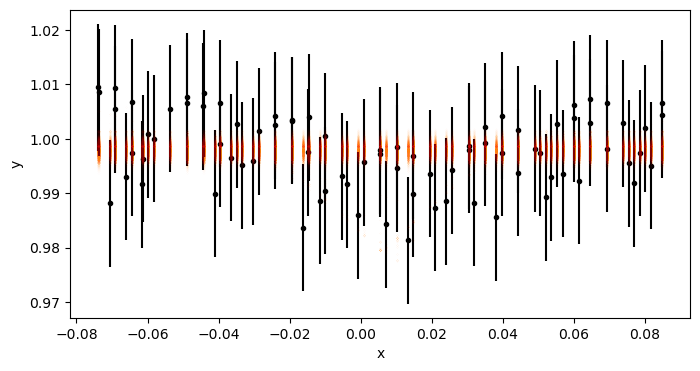

10 1583.159318555146
number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau
10,1583.159318555146,5.391254428883942,-4.392597520022626,0.009551142224474757,0.28382977623381633,5.153055294448214,26.453109132558826

shift_mins: 11.515170343291729  ; std_min: 342.1944878441495


In [91]:
from types import SimpleNamespace

etv_out_str = "number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau\n"


# convert lc to the form needed by fit etv_functions
lc_f_data = data_primary[(1570 < data_primary.time) & (data_primary.time < 1599)].copy()
lc_f_data.phase = lc_f_data.phase - mean_t0   # shift expected in to 0 phase  to make the result comparable to the regular runs above

start_vals = [mean_alpha0, mean_alpha1, 0, mean_d, mean_Tau]  
_alpha0, _alpha1, _t0, _d, _Tau, _fit_params_stats = etv_functions.run_mcmc_initial_fit(
    lc_f_data, start_vals, 
    # nruns=20, discard=1, 
    nruns=3000, discard=1000,
    autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)

_stdv_t0 = _fit_params_stats["std_t0"]
_t = np.mean(lc_f_data.time)  # approximate transit time 
_sector = 10
print(_sector, _t)

etv_out_str += ",".join([str(s) for s in [_sector, _t, _alpha0, _alpha1, _t0, _stdv_t0, _d, _Tau]])
etv_out_str += "\n"

print(etv_out_str)

# --- O-C in minutes ---
print("shift_mins:", _t0 * period * 24 * 60, " ; std_min:", _stdv_t0 * period * 24 * 60)  


## Results Summary

In [92]:
# FILL-IN the ETV results / comments
has_etv = "?"
comments = "O-C shows possilbe nonlinear ETV with ~ 7 - 20 d period. Highly uncertain with large errors."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True,
))

0
tic                                                                                             130946041
has_etv                                                                                                 ?
comments     O-C shows possilbe nonlinear ETV with ~ 7 - 20 d period. Highly uncertain with large errors.
period                                                                                           0.837245
depth_pct_p                                                                                          1.15
depth_pct_s                                                                                          0.55
epoch_p                                                                                       1570.988595
epoch_s                                                                                       1571.407217
num_sectors                                                                                             3
time_span                                                                                          1498.5
time_start                                                                                        1569.54
time_end                                                                                          3068.03


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
130946041,?,O-C shows possilbe nonlinear ETV with ~ 7 - 20 d period. Highly uncertain with large errors.,0.837245,1.15,0.55,1570.9885949999998,1571.4072174999997,3,1498.5,1569.54,3068.03

